In [1]:
# installing required libraries 

library(DT)

library(lattice)

library(knitr)

library(gplots)

library(ggplot2)

library(ClustOfVar)

library(ape)

library(Information)

library(ROCR)

library(caret)

library(rpart)


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


Attaching package: ‘Information’

The following object is masked _by_ ‘.GlobalEnv’:

    train

The following object is masked from ‘package:ape’:

    is.binary



In [2]:
# reading data 

cdata<-read.csv("german.csv",header=T)

# updating column names 

colnames(cdata) <- c("chk_ac_status_1",
                     "duration_month_2", "credit_history_3", "purpose_4",
                     "credit_amount_5","savings_ac_bond_6","p_employment_since_7",
                     "instalment_pct_8", "personal_status_9","other_debtors_or_grantors_10",
                     "present_residence_since_11","property_type_12","age_in_yrs_13",
                     "other_instalment_type_14", "housing_type_15",
                     "number_cards_this_bank_16","job_17","no_people_liable_for_mntnance_18",
                     "telephone_19", "foreign_worker_20",
                     "good_bad_21")

# creating functions for analysis. 

# create function to calculate percent distribution for factors 

pct <- function(x){
  tbl <- table(x)
  tbl_pct <- cbind(tbl,round(prop.table(tbl)*100,2))
  colnames(tbl_pct) <- c('Count','Percentage')
  kable(tbl_pct)
}

#  Own function to calculate IV, WOE and Efficiency- Prior to building a binary classification model, a common step is to perform variable screening and exploratory data analysis. This is the step where we get to know the data and weed out variables that are either ill-conditioned or simply contain no information that will help us predict the action of interest. The weight of evidence (WOE) and information value (IV) provide a great framework for for exploratory analysis and variable screening for binary classifiers. WOE and IV have been used extensively in the credit risk world for several decades, and the underlying theory dates back to the 1950s. However, it is still not widely used outside the credit risk world.

#WOE and IV enable one to:

#Consider each variable’s independent contribution to the outcome.

#Detect linear and non-linear relationships.
#Rank variables in terms of “univariate” predictive strength.
#Visualize the correlations between the predictive variables and the binary outcome.
#Seamlessly compare the strength of continuous and categorical variables without creating dummy variables.
#Seamlessly handle missing values without imputation.
#Assess the predictive power of missing values.


gbpct <- function(x, y=cdata$good_bad_21){
  mt <- as.matrix(table(as.factor(x), as.factor(y))) # x -> independent variable(vector), y->dependent variable(vector)
  Total <- mt[,1] + mt[,2] # Total observations
  Total_Pct <- round(Total/sum(mt)*100, 2) # Total PCT
  Bad_pct <- round((mt[,1]/sum(mt[,1]))*100, 2) # PCT of BAd or event or response
  Good_pct <- round((mt[,2]/sum(mt[,2]))*100, 2) # PCT of Good or non-event
  Bad_Rate <- round((mt[,1]/(mt[,1]+mt[,2]))*100, 2) # Bad rate or response rate
  grp_score <- round((Good_pct/(Good_pct + Bad_pct))*10, 2) # score for each group
  WOE <- round(log(Good_pct/Bad_pct)*10, 2) # Weight of Evidence for each group
  g_b_comp <- ifelse(mt[,1] == mt[,2], 0, 1)
  IV <- ifelse(g_b_comp == 0, 0, (Good_pct - Bad_pct)*(WOE/10)) # Information value for each group
  Efficiency <- abs(Good_pct - Bad_pct)/2 # Efficiency for each group
  otb<-as.data.frame(cbind(mt, Good_pct, Bad_pct, Total,
                           Total_Pct, Bad_Rate, grp_score,
                           WOE, IV, Efficiency ))
  otb$Names <- rownames(otb)
  rownames(otb) <- NULL
  otb[,c(12,2,1,3:11)] # return IV table
} 
#  function to normalize using Range 

normalize <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

# getting first hand feeling of the data , variable names of the data. You may create your own variable names. 

kable(as.data.frame(colnames(cdata)))



|colnames(cdata)                  |
|:--------------------------------|
|chk_ac_status_1                  |
|duration_month_2                 |
|credit_history_3                 |
|purpose_4                        |
|credit_amount_5                  |
|savings_ac_bond_6                |
|p_employment_since_7             |
|instalment_pct_8                 |
|personal_status_9                |
|other_debtors_or_grantors_10     |
|present_residence_since_11       |
|property_type_12                 |
|age_in_yrs_13                    |
|other_instalment_type_14         |
|housing_type_15                  |
|number_cards_this_bank_16        |
|job_17                           |
|no_people_liable_for_mntnance_18 |
|telephone_19                     |
|foreign_worker_20                |
|good_bad_21                      |

In [3]:
# structure of the data, 

str(cdata)

'data.frame':	1000 obs. of  21 variables:
 $ chk_ac_status_1                 : Factor w/ 4 levels "A11","A12","A13",..: 1 2 4 1 1 4 4 2 4 2 ...
 $ duration_month_2                : int  6 48 12 42 24 36 24 36 12 30 ...
 $ credit_history_3                : Factor w/ 5 levels "A30","A31","A32",..: 5 3 5 3 4 3 3 3 3 5 ...
 $ purpose_4                       : Factor w/ 10 levels "A40","A41","A410",..: 5 5 8 4 1 8 4 2 5 1 ...
 $ credit_amount_5                 : int  1169 5951 2096 7882 4870 9055 2835 6948 3059 5234 ...
 $ savings_ac_bond_6               : Factor w/ 5 levels "A61","A62","A63",..: 5 1 1 1 1 5 3 1 4 1 ...
 $ p_employment_since_7            : Factor w/ 5 levels "A71","A72","A73",..: 5 3 4 4 3 3 5 3 4 1 ...
 $ instalment_pct_8                : int  4 2 2 2 3 2 3 2 2 4 ...
 $ personal_status_9               : Factor w/ 4 levels "A91","A92","A93",..: 3 2 3 3 3 3 3 3 1 4 ...
 $ other_debtors_or_grantors_10    : Factor w/ 3 levels "A101","A102",..: 1 1 1 3 1 1 1 1 1 1 ...
 $ presen

In [4]:
#summary of the data 

summary(cdata)

 chk_ac_status_1 duration_month_2 credit_history_3   purpose_4  
 A11:274         Min.   : 4.0     A30: 40          A43    :280  
 A12:269         1st Qu.:12.0     A31: 49          A40    :234  
 A13: 63         Median :18.0     A32:530          A42    :181  
 A14:394         Mean   :20.9     A33: 88          A41    :103  
                 3rd Qu.:24.0     A34:293          A49    : 97  
                 Max.   :72.0                      A46    : 50  
                                                   (Other): 55  
 credit_amount_5 savings_ac_bond_6 p_employment_since_7 instalment_pct_8
 Min.   :  250   A61:603           A71: 62              Min.   :1.000   
 1st Qu.: 1366   A62:103           A72:172              1st Qu.:2.000   
 Median : 2320   A63: 63           A73:339              Median :3.000   
 Mean   : 3271   A64: 48           A74:174              Mean   :2.973   
 3rd Qu.: 3972   A65:183           A75:253              3rd Qu.:4.000   
 Max.   :18424                            

In [6]:
# Modify variable types. We may need to convert data types of certain variables based on their properties. 

cdata$duration_month_2 <- as.numeric(cdata$duration_month_2)

cdata$credit_amount_5 <- as.numeric(cdata$credit_amount_5 )

cdata$instalment_pct_8 <- as.numeric(cdata$instalment_pct_8)

cdata$present_residence_since_11 <- as.numeric(cdata$present_residence_since_11)

cdata$age_in_yrs_13 <- as.numeric(cdata$age_in_yrs_13)

cdata$number_cards_this_bank_16 <- as.numeric(cdata$number_cards_this_bank_16)

cdata$no_people_liable_for_mntnance_18 < as.numeric(cdata$no_people_liable_for_mntnance_18)


[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [61] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [73] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [85] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
  [97] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [109] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [133] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [145] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [157] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [169] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [217] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [229] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [241] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [253] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [265] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [277] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [289] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [301] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [313] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [325] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [337] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [349] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [361] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [373] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [385] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [397] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [409] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [421] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [433] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [445] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [457] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [469] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [481] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [493] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [505] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [517] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [529] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [541] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [553] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [565] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [577] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [589] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [601] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALS

In [7]:
# Good-bad and univariate analysis- analyze good_bad (1-good, 2-bad)



cdata$good_bad_21<-as.factor(ifelse(cdata$good_bad_21 == 1, "Good", "Bad"))

pct(cdata$good_bad_21)



|     | Count| Percentage|
|:----|-----:|----------:|
|Bad  |   700|         70|
|Good |   300|         30|

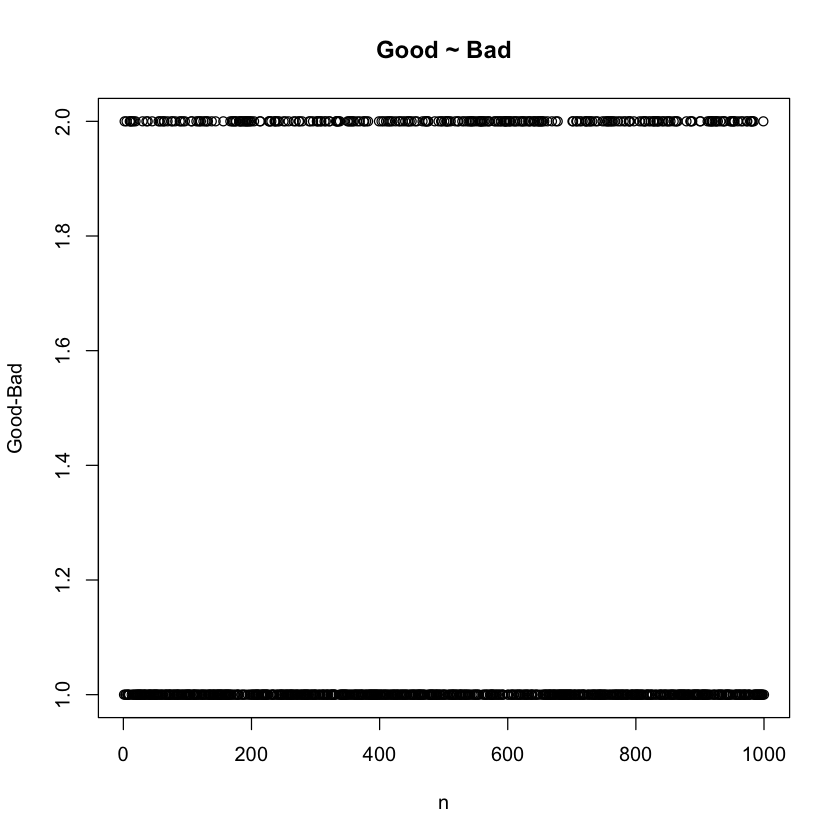

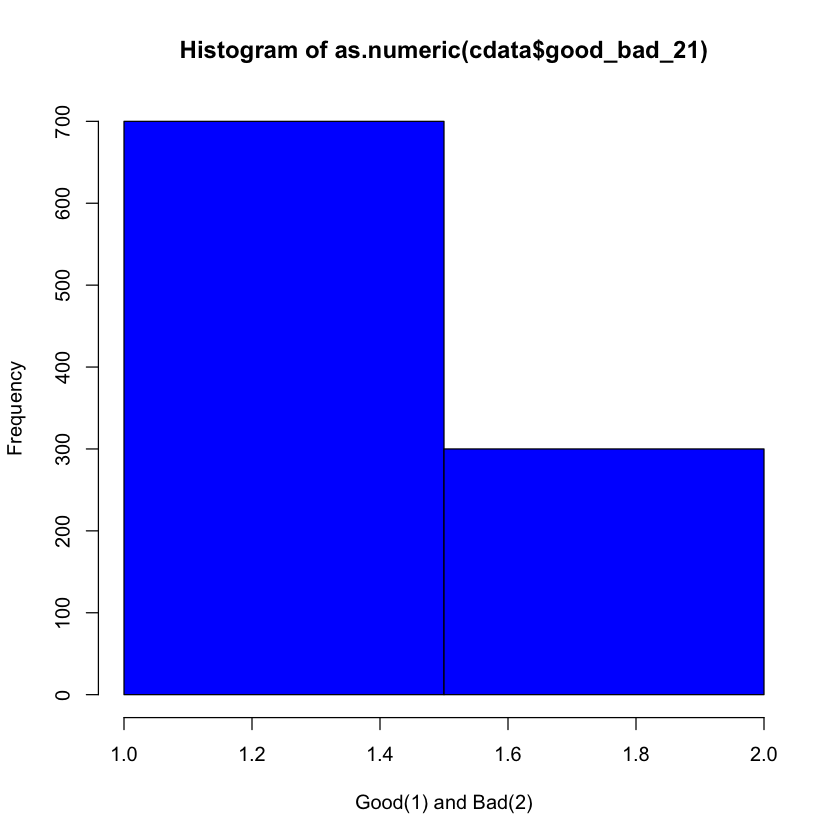

In [8]:
plot(as.numeric(cdata$good_bad_21), ylab="Good-Bad", xlab="n", main="Good ~ Bad")

hist(as.numeric(cdata$good_bad_21), breaks=2,
     xlab="Good(1) and Bad(2)", col="blue")
# This explains that bad loans are higher than good loans
# Univariate and bi variate analysis checking account status 

A1<-gbpct(cdata$chk_ac_status_1)


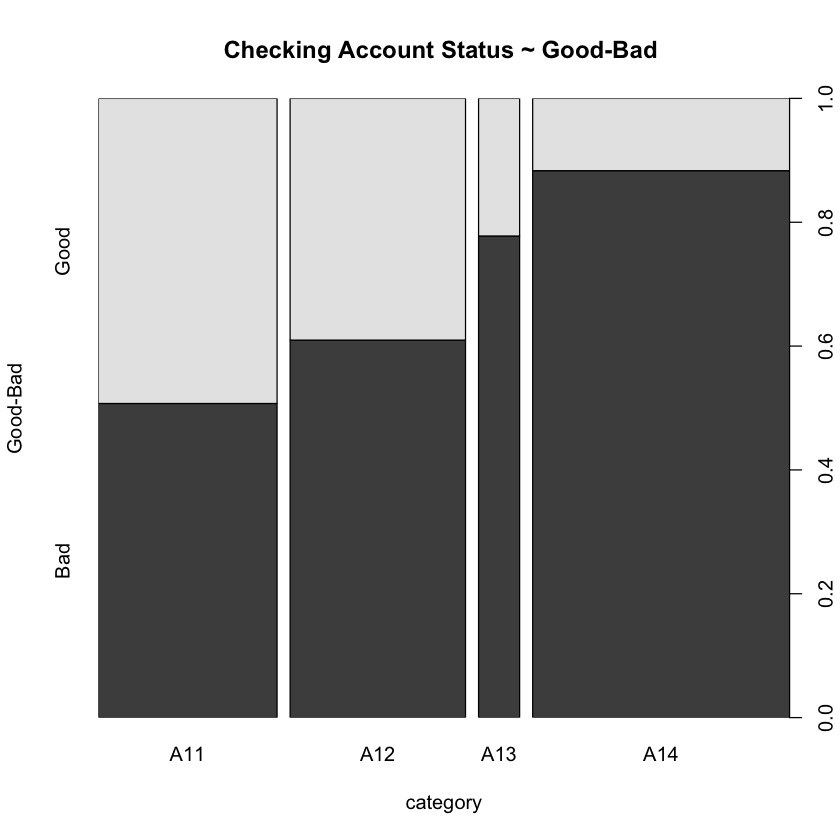

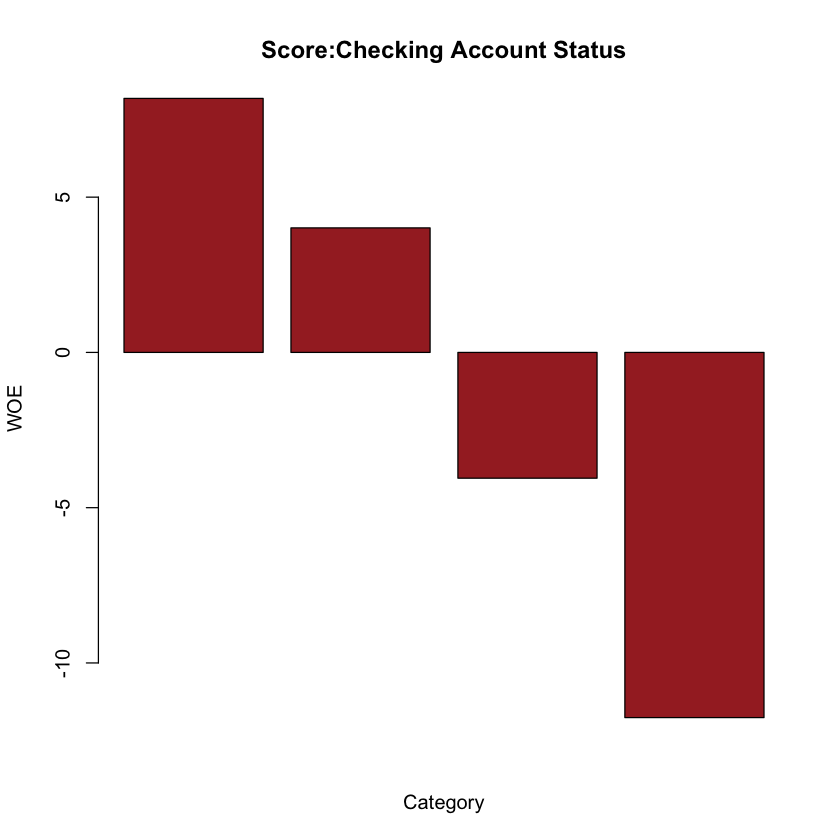

In [9]:
plot(cdata$chk_ac_status_1, cdata$good_bad_21,
     ylab="Good-Bad", xlab="category",
     main="Checking Account Status ~ Good-Bad ")

barplot(A1$WOE, col="brown", names.arg=c(A1$Levels),
        main="Score:Checking Account Status",
        xlab="Category",
        ylab="WOE"
)

In [10]:
kable(A1, caption = 'Checking Account Status ~ Good-Bad')



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|    WOE|       IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|------:|--------:|----------:|
|A11   |  135| 139|    45.00|   19.86|   274|      27.4|    50.73|      6.94|   8.18| 20.56452|     12.570|
|A12   |  105| 164|    35.00|   23.43|   269|      26.9|    60.97|      5.99|   4.01|  4.63957|      5.785|
|A13   |   14|  49|     4.67|    7.00|    63|       6.3|    77.78|      4.00|  -4.05|  0.94365|      1.165|
|A14   |   46| 348|    15.33|   49.71|   394|      39.4|    88.32|      2.36| -11.76| 40.43088|     17.190|

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    4.0    12.0    18.0    20.9    24.0    72.0 

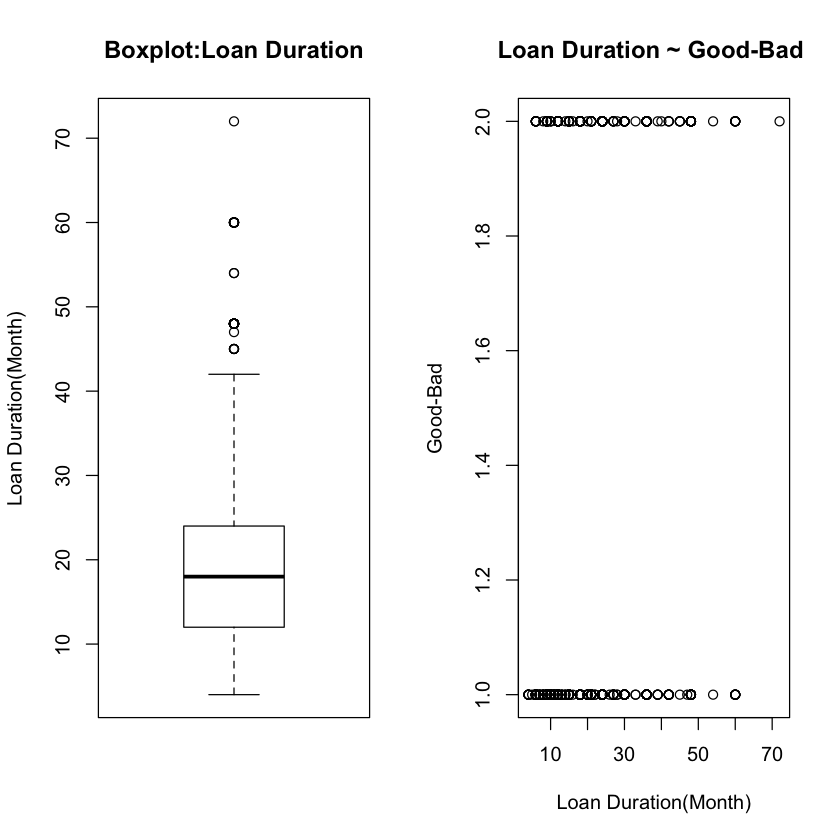

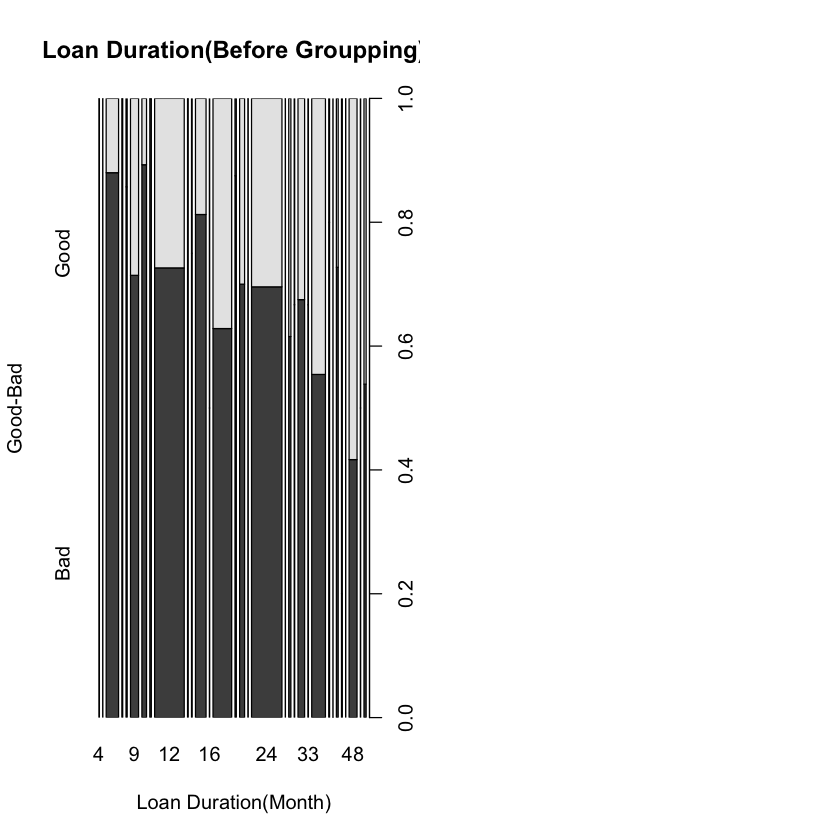

In [11]:
#Loan Duration 

summary(cdata$duration_month_2)

op2<-par(mfrow=c(1,2))

boxplot(cdata$duration_month_2, ylab="Loan Duration(Month)", main="Boxplot:Loan Duration")

plot(cdata$duration_month_2, cdata$good_bad_21,
     ylab="Good-Bad", xlab="Loan Duration(Month)",
     main="Loan Duration ~ Good-Bad ")

plot(as.factor(cdata$duration_month_2), cdata$good_bad_21,
     ylab="Good-Bad", xlab="Loan Duration(Month)",
     main="Loan Duration(Before Groupping)")

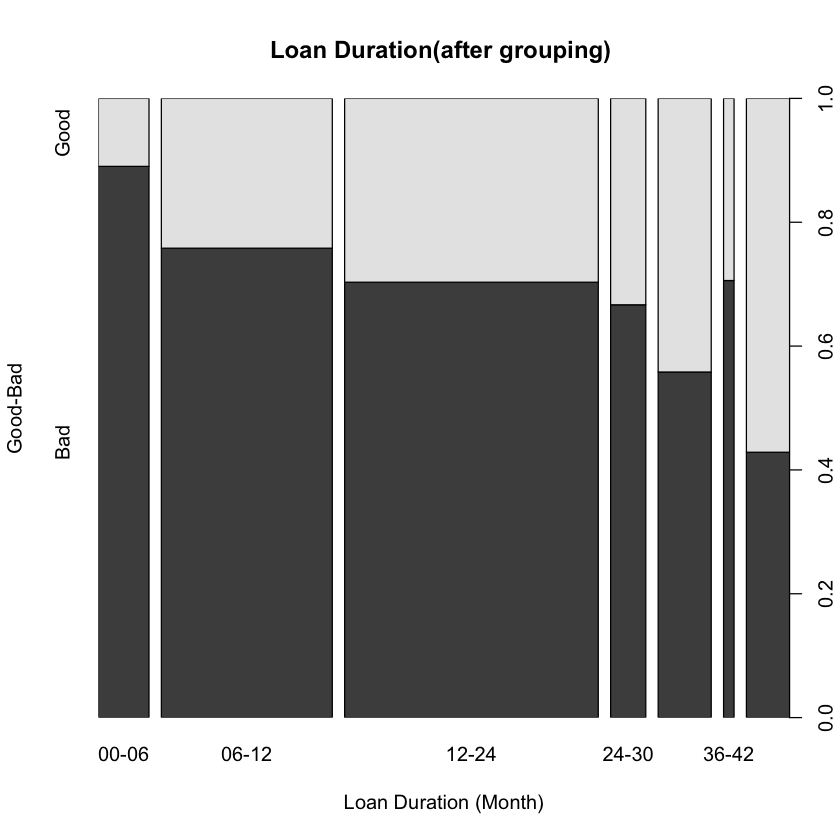

In [12]:
#create some groups from continuous variables 

cdata$duration_month_2<-as.factor(ifelse(cdata$duration_month_2<=6,'00-06',ifelse(cdata$duration_month_2<=12,'06-12',ifelse(cdata$duration_month_2<=24,'12-24',ifelse(cdata$duration_month_2<=30,'24-30',ifelse(cdata$duration_month_2<=36,'30-36',ifelse(cdata$duration_month_2<=42,'36-42','42+')))))))


plot(cdata$duration_month_2, cdata$good_bad_21,
     main="Loan Duration(after grouping) ",
     xlab="Loan Duration (Month)",
     ylab="Good-Bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|    WOE|       IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|------:|--------:|----------:|
|00-06 |    9|  73|     3.00|   10.43|    82|       8.2|    89.02|      2.23| -12.46|  9.25778|      3.715|
|06-12 |   67| 210|    22.33|   30.00|   277|      27.7|    75.81|      4.27|  -2.95|  2.26265|      3.835|
|12-24 |  122| 289|    40.67|   41.29|   411|      41.1|    70.32|      4.96|  -0.15|  0.00930|      0.310|
|24-30 |   19|  38|     6.33|    5.43|    57|       5.7|    66.67|      5.38|   1.53|  0.13770|      0.450|
|30-36 |   38|  48|    12.67|    6.86|    86|       8.6|    55.81|      6.49|   6.14|  3.56734|      2.905|
|36-42 |    5|  12|     1.67|    1.71|    17|       1.7|    70.59|      4.94|  -0.24|  0.00096|      0.020|
|42+   |   40|  30|    13.33|    4.29|    70|       7.0|    42.86|      7.57|  11.34| 10.25136|      4.520|

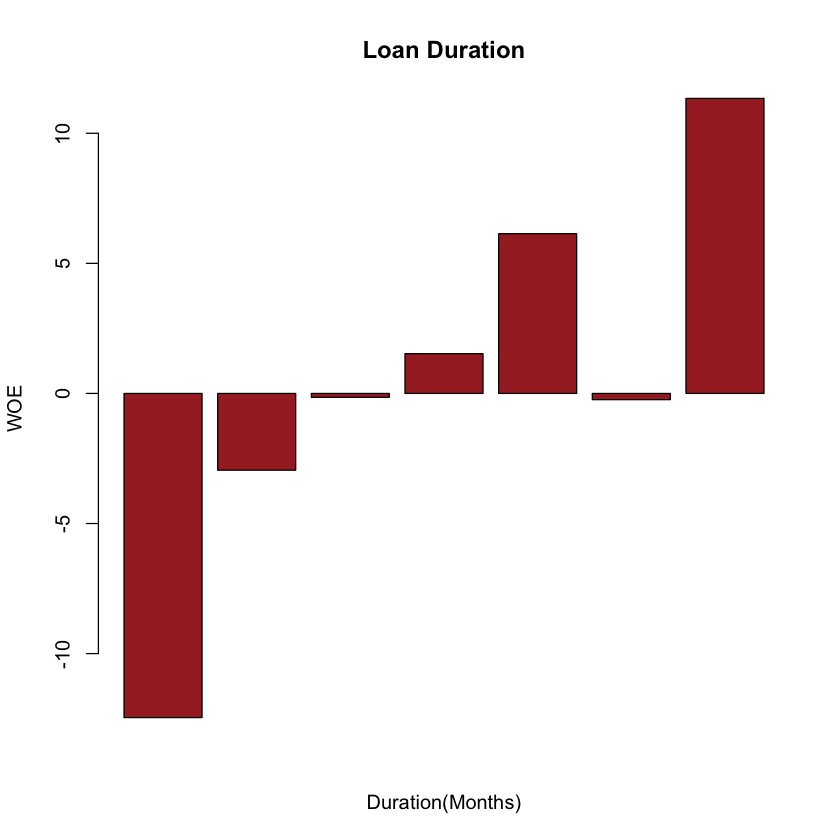

In [13]:
A2<-gbpct(cdata$duration_month_2)
barplot(A2$WOE, col="brown", names.arg=c(A2$Levels),
        main="Loan Duration",
        xlab="Duration(Months)",
        ylab="WOE"
)

kable(A2, caption = 'Loan Duration ~ Good-Bad')

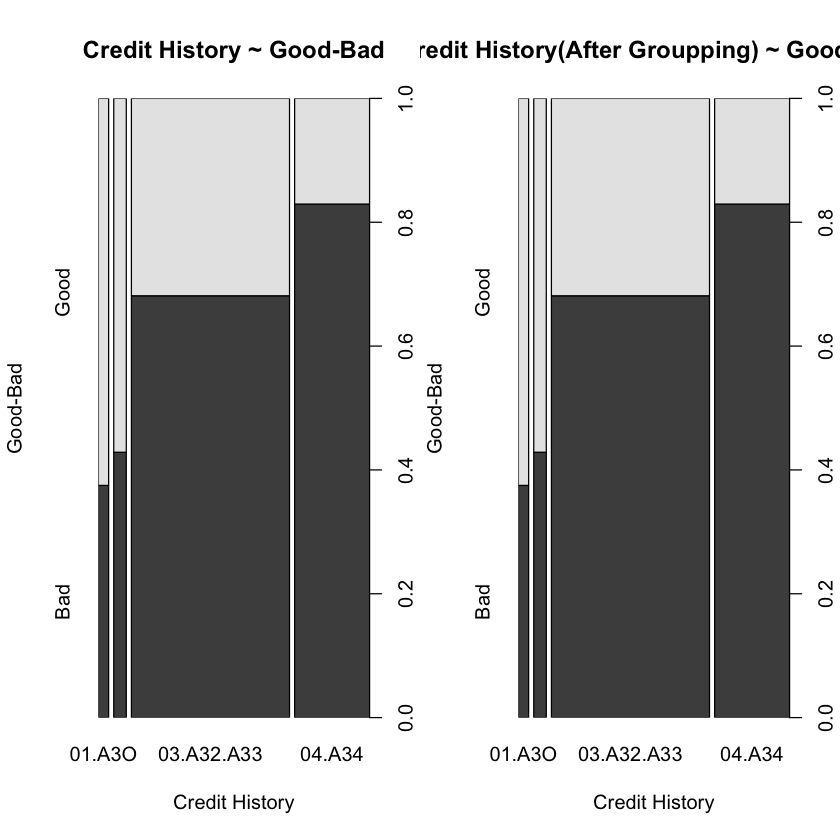

In [14]:
# Attribute 3: Credit history (qualitative)
#-----------------------------------------------------------
# Credit History
# A30 : no credits taken/
# all credits paid back duly
# A31 : all credits at this bank paid back duly
# A32 : existing credits paid back duly till now
# A33 : delay in paying off in the past
# A34 : critical account/
# other credits existing (not at this bank)

# Combine few groups together based on WOE and bad rates

cdata$credit_history_3<-as.factor(ifelse(cdata$credit_history_3=="A30",'01.A3O', ifelse(cdata$credit_history_3=="A31","02.A31",ifelse(cdata$credit_history_3=="A32",'03.A32.A33',ifelse(cdata$credit_history_3=="A33","03.A32.A33","04.A34")))))

op3<-par(mfrow=c(1,2))
plot(cdata$credit_history_3, cdata$good_bad_21,
     main = "Credit History ~ Good-Bad",
     xlab = "Credit History",
     ylab = "Good-Bad")
plot(cdata$credit_history_3, cdata$good_bad_21,
     main = "Credit History(After Groupping) ~ Good-Bad ",
     xlab = "Credit History",
     ylab = "Good-Bad")



|Names      | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|       IV| Efficiency|
|:----------|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|--------:|----------:|
|01.A3O     |   25|  15|     8.33|    2.14|    40|       4.0|    37.50|      7.96| 13.59|  8.41221|      3.095|
|02.A31     |   28|  21|     9.33|    3.00|    49|       4.9|    42.86|      7.57| 11.35|  7.18455|      3.165|
|03.A32.A33 |  197| 421|    65.67|   60.14|   618|      61.8|    68.12|      5.22|  0.88|  0.48664|      2.765|
|04.A34     |   50| 243|    16.67|   34.71|   293|      29.3|    82.94|      3.24| -7.33| 13.22332|      9.020|

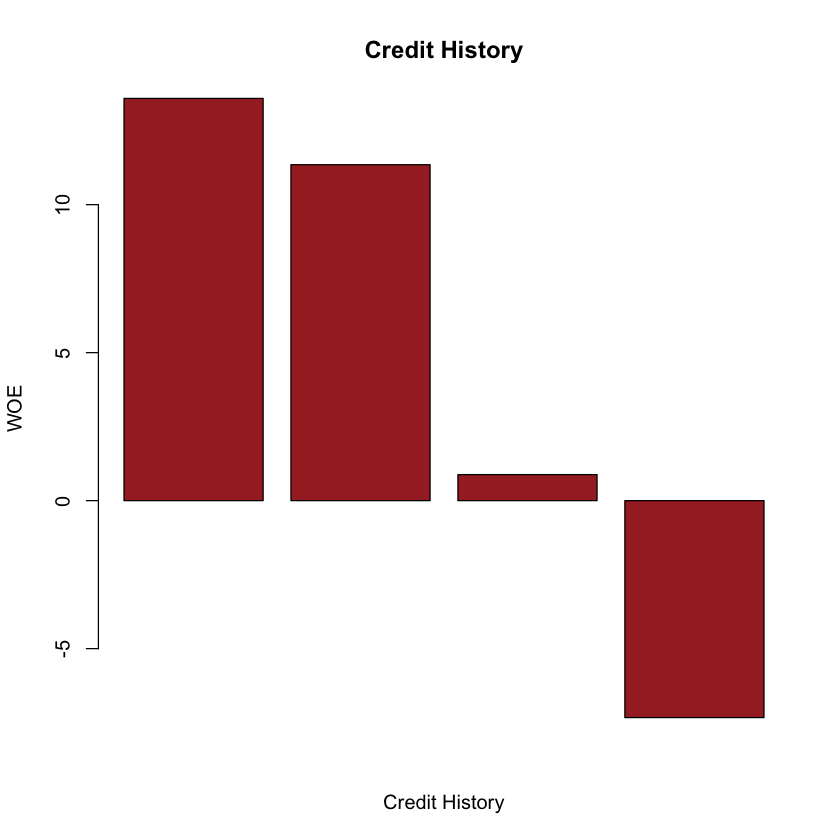

In [16]:
par(op3)
A3<-gbpct(cdata$credit_history_3)
barplot(A3$WOE, col="brown", names.arg=c(A3$Levels),
        main="Credit History",
        xlab="Credit History",
        ylab="WOE"
)
kable(A3, caption = "Credit History~ Good-Bad")

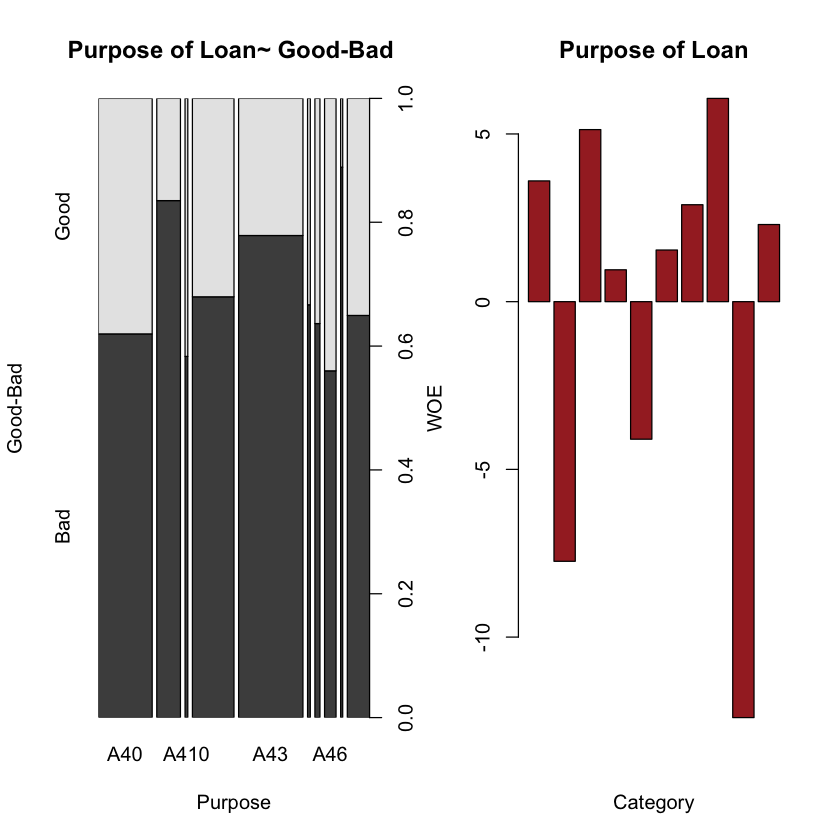

In [17]:
# Attribute 4: (qualitative)
#-----------------------------------------------------------
# Purpose of the loan
#
# A40 : car (new)
# A41 : car (used)
# A42 : furniture/equipment
# A43 : radio/television
# A44 : domestic appliances
# A45 : repairs
# A46 : education
# A47 : (vacation - does not exist?)
# A48 : retraining
# A49 : business
# A410 : others

A4<-gbpct(cdata$purpose_4)

op4<-par(mfrow=c(1,2))
plot(cdata$purpose_4, cdata$good_bad_21,
     main="Purpose of Loan~ Good-Bad ",
     xlab="Purpose",
     ylab="Good-Bad")

barplot(A4$WOE, col="brown", names.arg=c(A4$Levels),
        main="Purpose of Loan",
        xlab="Category",
        ylab="WOE")

In [18]:
kable(A4, caption = "Purpose of Loan~ Good-Bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|    WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|------:|-------:|----------:|
|A40   |   89| 145|    29.67|   20.71|   234|      23.4|    61.97|      5.89|   3.60| 3.22560|      4.480|
|A41   |   17|  86|     5.67|   12.29|   103|      10.3|    83.50|      3.16|  -7.74| 5.12388|      3.310|
|A410  |    5|   7|     1.67|    1.00|    12|       1.2|    58.33|      6.25|   5.13| 0.34371|      0.335|
|A42   |   58| 123|    19.33|   17.57|   181|      18.1|    67.96|      5.24|   0.95| 0.16720|      0.880|
|A43   |   62| 218|    20.67|   31.14|   280|      28.0|    77.86|      3.99|  -4.10| 4.29270|      5.235|
|A44   |    4|   8|     1.33|    1.14|    12|       1.2|    66.67|      5.38|   1.54| 0.02926|      0.095|
|A45   |    8|  14|     2.67|    2.00|    22|       2.2|    63.64|      5.72|   2.89| 0.19363|      0.335|
|A46   |   22|  28|     7.33|    4.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    250    1366    2320    3271    3972   18424 

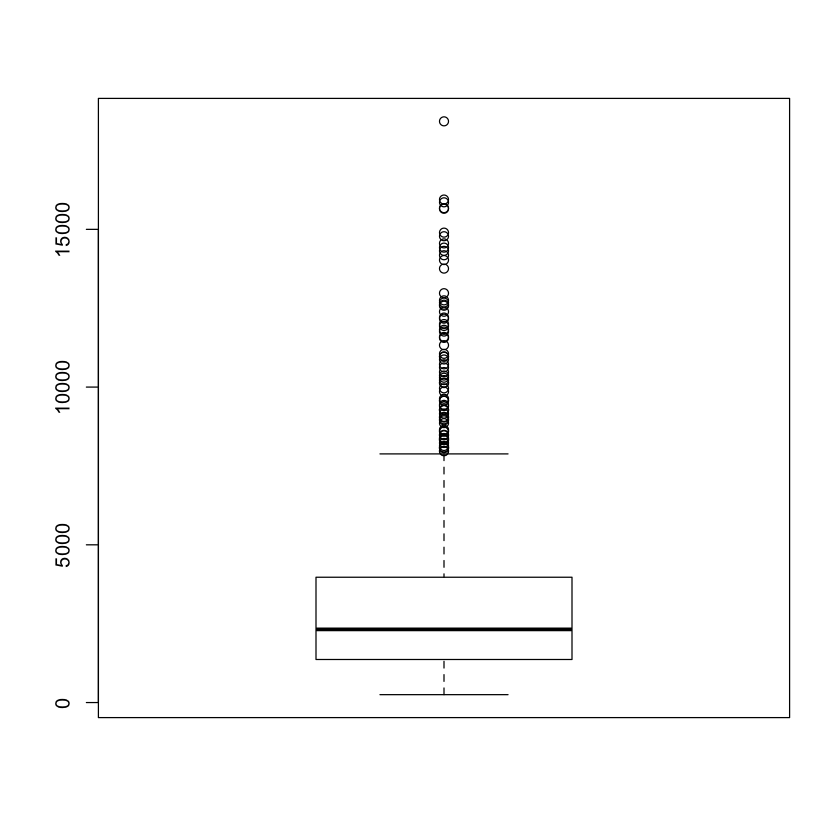

In [19]:
# Attribute 5: (numerical)
#-----------------------------------------------------------
# Credit (Loan) Amount
cdata$credit_amount_5 <- as.double(cdata$credit_amount_5)
summary(cdata$credit_amount_5)
boxplot(cdata$credit_amount_5)

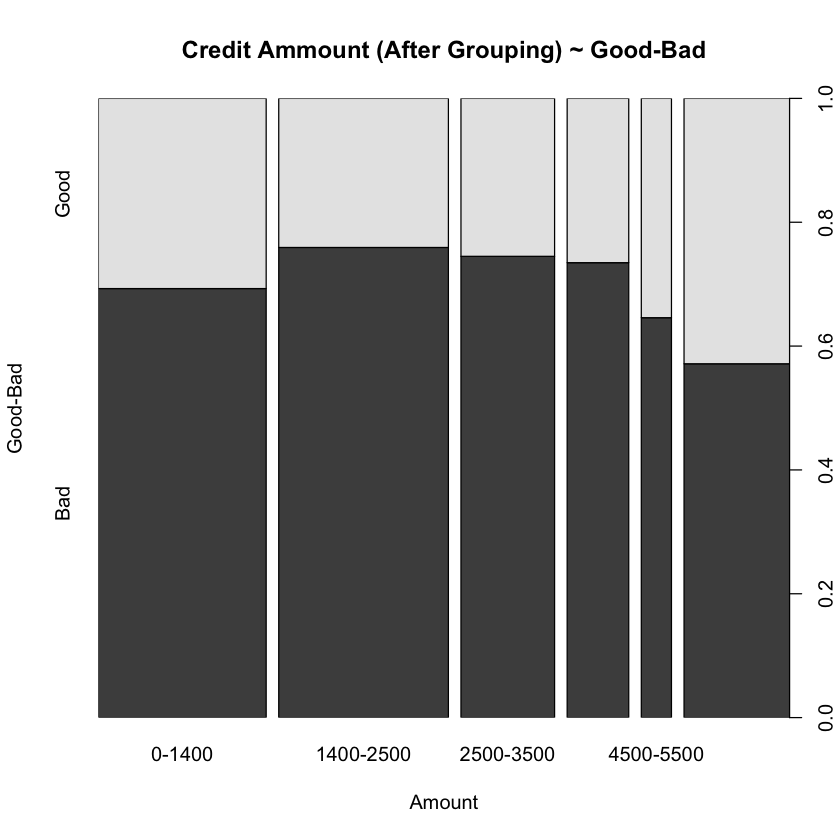

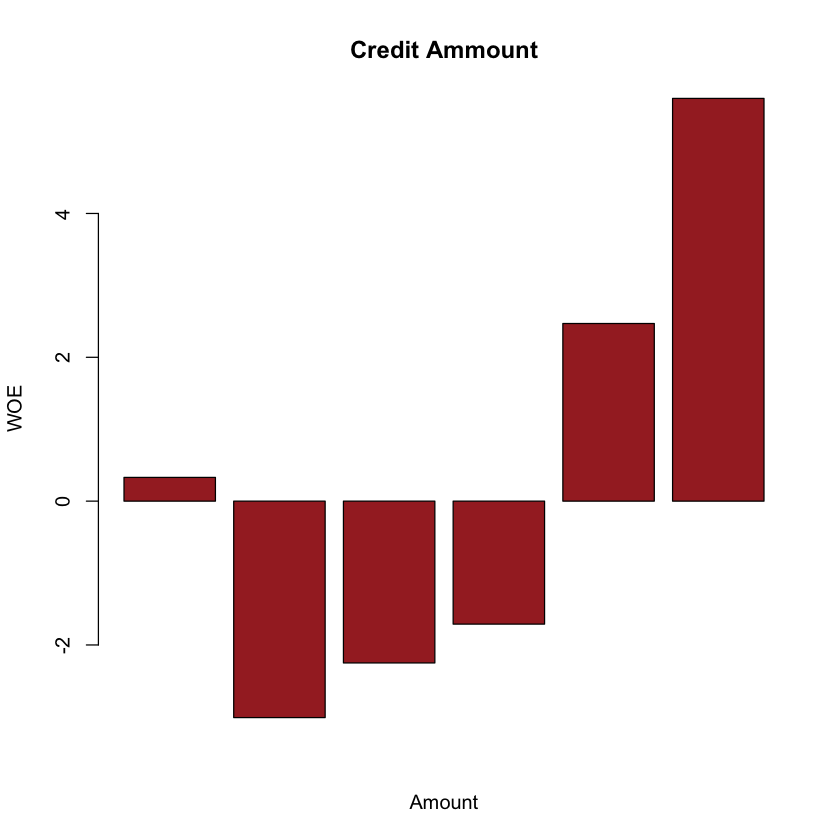

In [20]:
# Create groups based on their distribution

cdata$credit_amount_5<-as.factor(ifelse(cdata$credit_amount_5<=1400,'0-1400',ifelse(cdata$credit_amount_5<=2500,'1400-2500',ifelse(cdata$credit_amount_5<=3500,'2500-3500',ifelse(cdata$credit_amount_5<=4500,'3500-4500',ifelse(cdata$credit_amount_5<=5500,'4500-5500','5500+'))))))


A5<-gbpct(cdata$credit_amount_5)

plot(cdata$credit_amount_5, cdata$good_bad_21,
     main="Credit Ammount (After Grouping) ~ Good-Bad",
     xlab="Amount",
     ylab="Good-Bad")

barplot(A5$WOE, col="brown", names.arg=c(A5$Levels),
        main="Credit Ammount",
        xlab="Amount",
        ylab="WOE")

In [21]:
kable(A5, caption = "Credit Ammount ~ Good-Bad")



|Names     | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:---------|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|0-1400    |   82| 185|    27.33|   26.43|   267|      26.7|    69.29|      5.08|  0.33| 0.02970|      0.450|
|1400-2500 |   65| 205|    21.67|   29.29|   270|      27.0|    75.93|      4.25| -3.01| 2.29362|      3.810|
|2500-3500 |   38| 111|    12.67|   15.86|   149|      14.9|    74.50|      4.44| -2.25| 0.71775|      1.595|
|3500-4500 |   26|  72|     8.67|   10.29|    98|       9.8|    73.47|      4.57| -1.71| 0.27702|      0.810|
|4500-5500 |   17|  31|     5.67|    4.43|    48|       4.8|    64.58|      5.61|  2.47| 0.30628|      0.620|
|5500+     |   72|  96|    24.00|   13.71|   168|      16.8|    57.14|      6.36|  5.60| 5.76240|      5.145|

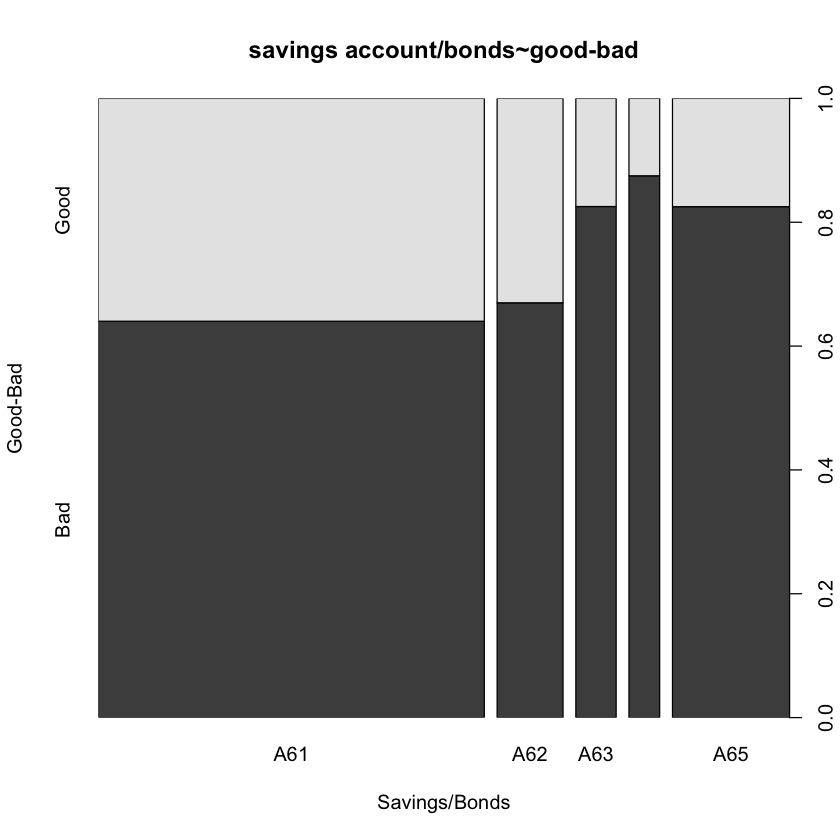

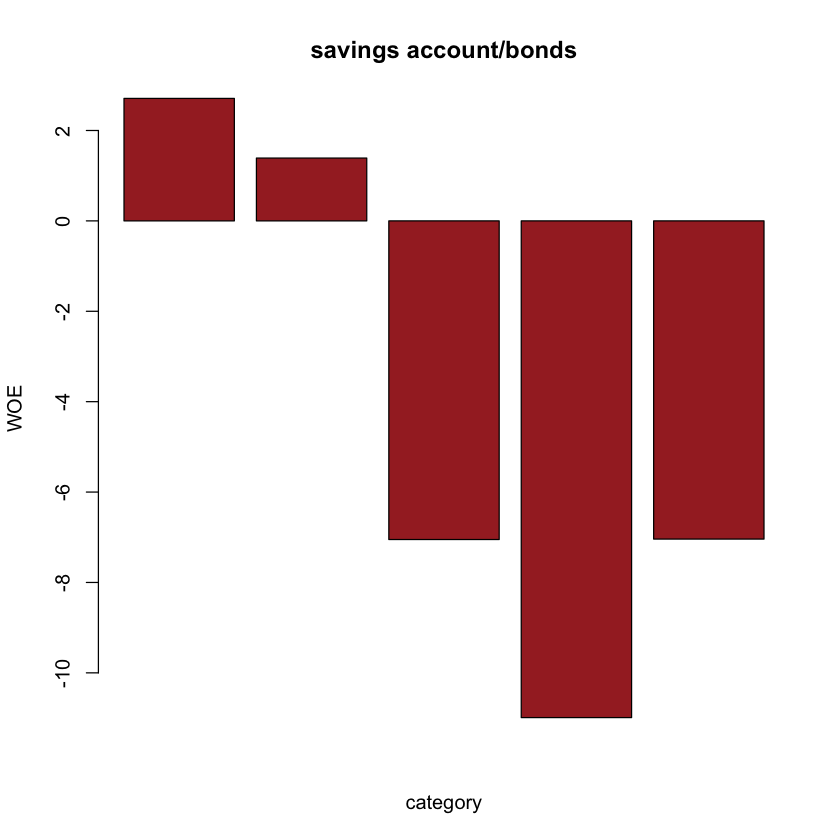

In [22]:
#Saving account/bonds

A6<-gbpct(cdata$savings_ac_bond_6)
plot(cdata$savings_ac_bond_6,cdata$good_bad_21,main="savings account/bonds~good-bad",xlab="Savings/Bonds",ylab="Good-Bad")
barplot(A6$WOE,col="brown",names.arg=c(A6$Levels),main="savings account/bonds",xlab="category",ylab="WOE")

In [23]:
kable(A6,caption="Savings account/bonds~Good-Bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|    WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|------:|-------:|----------:|
|A61   |  217| 386|    72.33|   55.14|   603|      60.3|    64.01|      5.67|   2.71| 4.65849|      8.595|
|A62   |   34|  69|    11.33|    9.86|   103|      10.3|    66.99|      5.35|   1.39| 0.20433|      0.735|
|A63   |   11|  52|     3.67|    7.43|    63|       6.3|    82.54|      3.31|  -7.05| 2.65080|      1.880|
|A64   |    6|  42|     2.00|    6.00|    48|       4.8|    87.50|      2.50| -10.99| 4.39600|      2.000|
|A65   |   32| 151|    10.67|   21.57|   183|      18.3|    82.51|      3.31|  -7.04| 7.67360|      5.450|

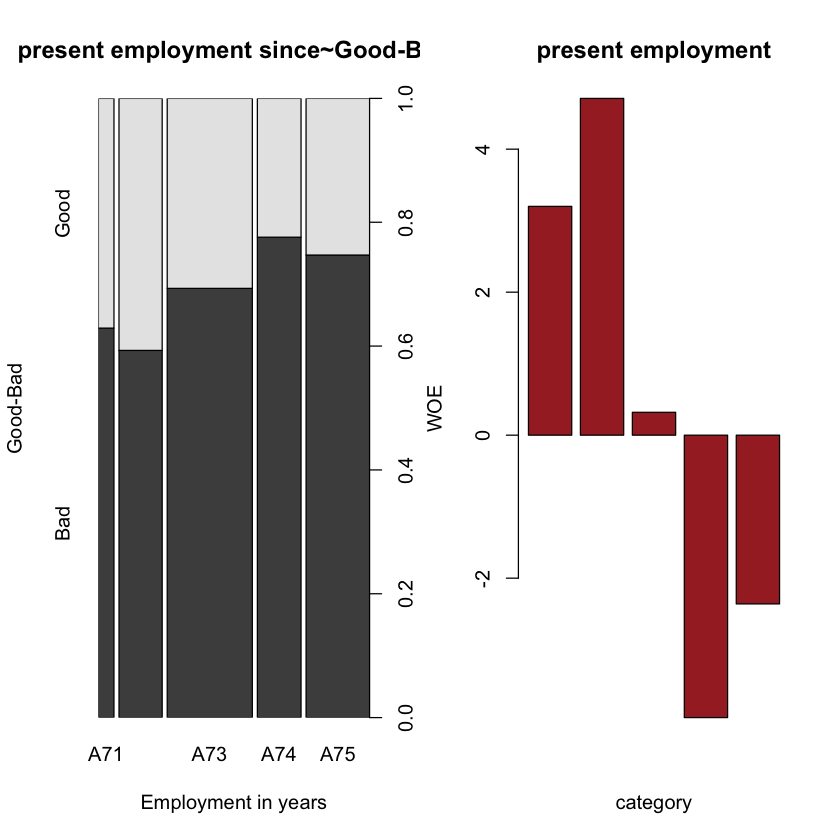

In [24]:
#Present employment since 

A7<-gbpct(cdata$p_employment_since_7)
op7<-par(mfrow=c(1,2))
plot(cdata$p_employment_since_7,cdata$good_bad_21,main="present employment since~Good-Bad",xlab="Employment in years",ylab="Good-Bad")
barplot(A7$WOE,col="brown",names.arg=c(A7$Levels),main="present employment",xlab="category",ylab="WOE")

In [25]:
kable(A7,caption="present employment since~Good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|A71   |   23|  39|     7.67|    5.57|    62|       6.2|    62.90|      5.79|  3.20| 0.67200|      1.050|
|A72   |   70| 102|    23.33|   14.57|   172|      17.2|    59.30|      6.16|  4.71| 4.12596|      4.380|
|A73   |  104| 235|    34.67|   33.57|   339|      33.9|    69.32|      5.08|  0.32| 0.03520|      0.550|
|A74   |   39| 135|    13.00|   19.29|   174|      17.4|    77.59|      4.03| -3.95| 2.48455|      3.145|
|A75   |   64| 189|    21.33|   27.00|   253|      25.3|    74.70|      4.41| -2.36| 1.33812|      2.835|

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   2.973   4.000   4.000 

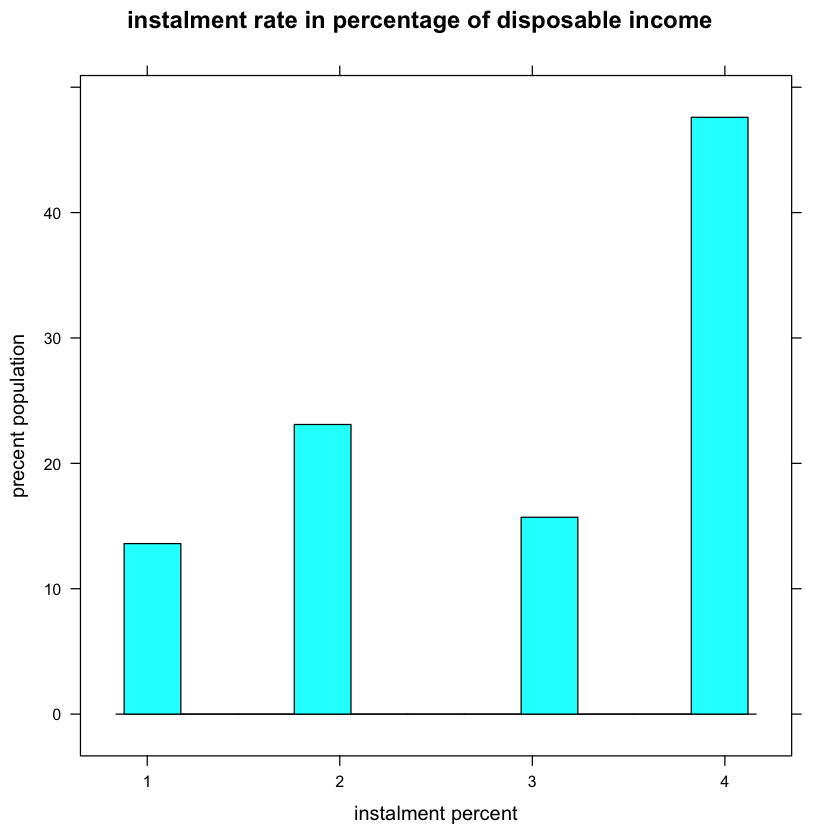

In [26]:
summary(cdata$instalment_pct_8)
op8<-par(mfrow=c(1,2))
boxplot(cdata$instalment_pct_8)
histogram(cdata$instalment_pct_8,main="instalment rate in percentage of disposable income",xlab="instalment percent",ylab="precent population")

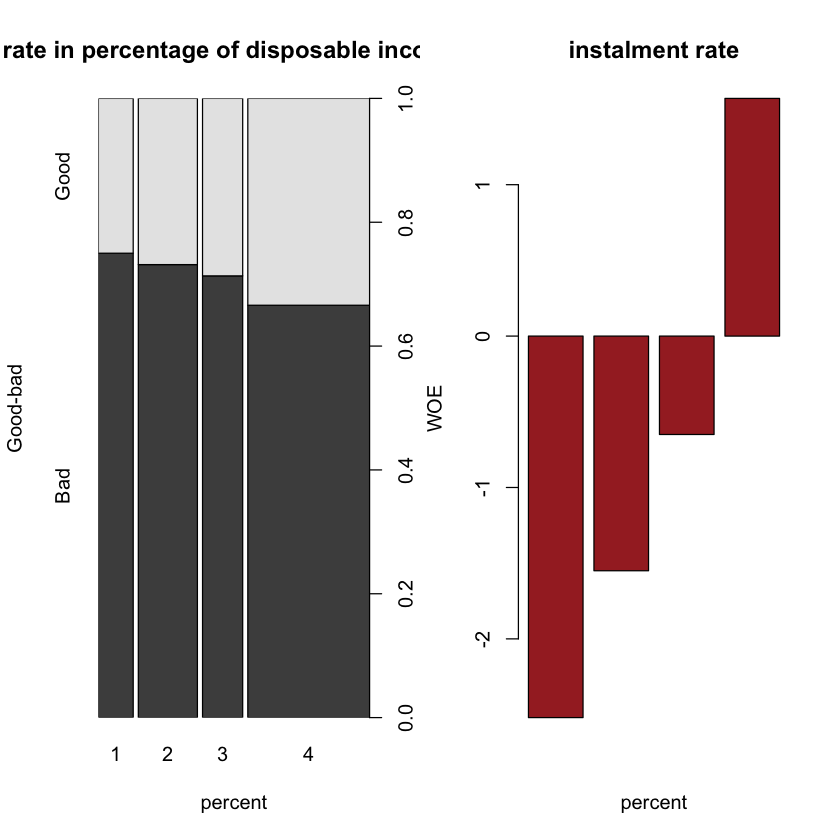

In [27]:
A8<-gbpct(cdata$instalment_pct_8)
op8_1<-par(mfrow=c(1,2))
plot(as.factor(cdata$instalment_pct_8),cdata$good_bad_21,main="instalment rate in percentage of disposable income ~good-bad",xlab="percent",ylab="Good-bad")
barplot(A8$WOE,col="brown",names.arg=c(A8$Levels),main="instalment rate",xlab="percent",ylab="WOE")

In [28]:
par(op8_1)
kable(A8,caption="instalment rate in percentage of disposable income~good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|1     |   34| 102|    11.33|   14.57|   136|      13.6|    75.00|      4.37| -2.52| 0.81648|      1.620|
|2     |   62| 169|    20.67|   24.14|   231|      23.1|    73.16|      4.61| -1.55| 0.53785|      1.735|
|3     |   45| 112|    15.00|   16.00|   157|      15.7|    71.34|      4.84| -0.65| 0.06500|      0.500|
|4     |  159| 317|    53.00|   45.29|   476|      47.6|    66.60|      5.39|  1.57| 1.21047|      3.855|

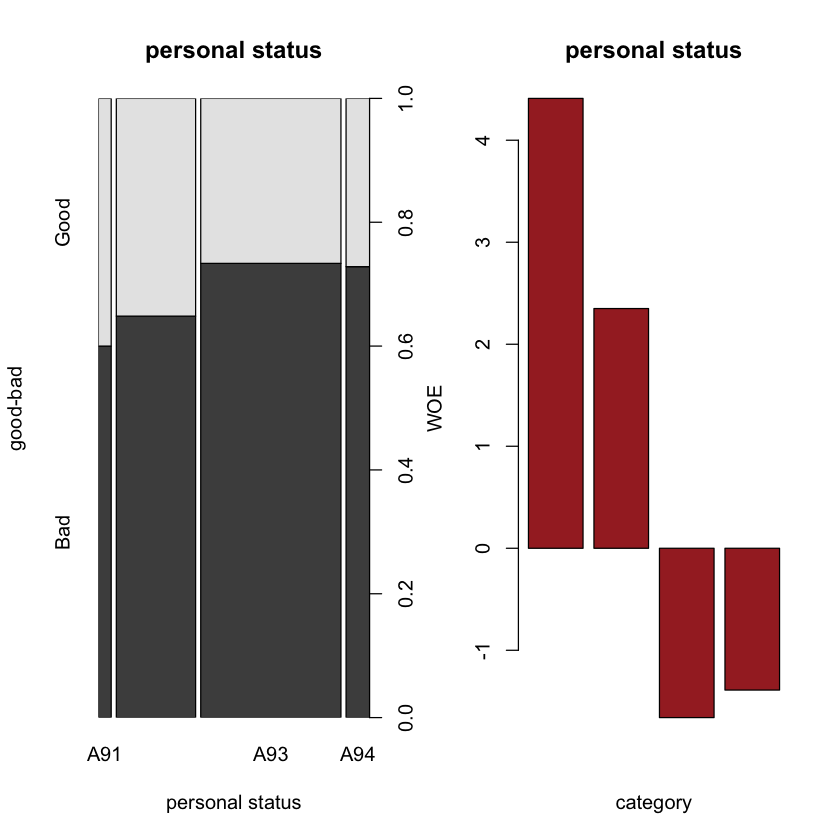

In [29]:
#personal status and sex

A9<-gbpct(cdata$personal_status_9)
op9<-par(mfrow=c(1,2))
plot(cdata$personal_status_9,cdata$good_bad_21,main="personal status",xlab="personal status",ylab="good-bad")
barplot(A9$WOE,col="brown",names.arg=c(A9$Levels),main="personal status",xlab="category",ylab="WOE")

In [30]:
kable(A9,caption="personal status~good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|A91   |   20|  30|     6.67|    4.29|    50|       5.0|    60.00|      6.09|  4.41| 1.04958|       1.19|
|A92   |  109| 201|    36.33|   28.71|   310|      31.0|    64.84|      5.59|  2.35| 1.79070|       3.81|
|A93   |  146| 402|    48.67|   57.43|   548|      54.8|    73.36|      4.59| -1.66| 1.45416|       4.38|
|A94   |   25|  67|     8.33|    9.57|    92|       9.2|    72.83|      4.65| -1.39| 0.17236|       0.62|

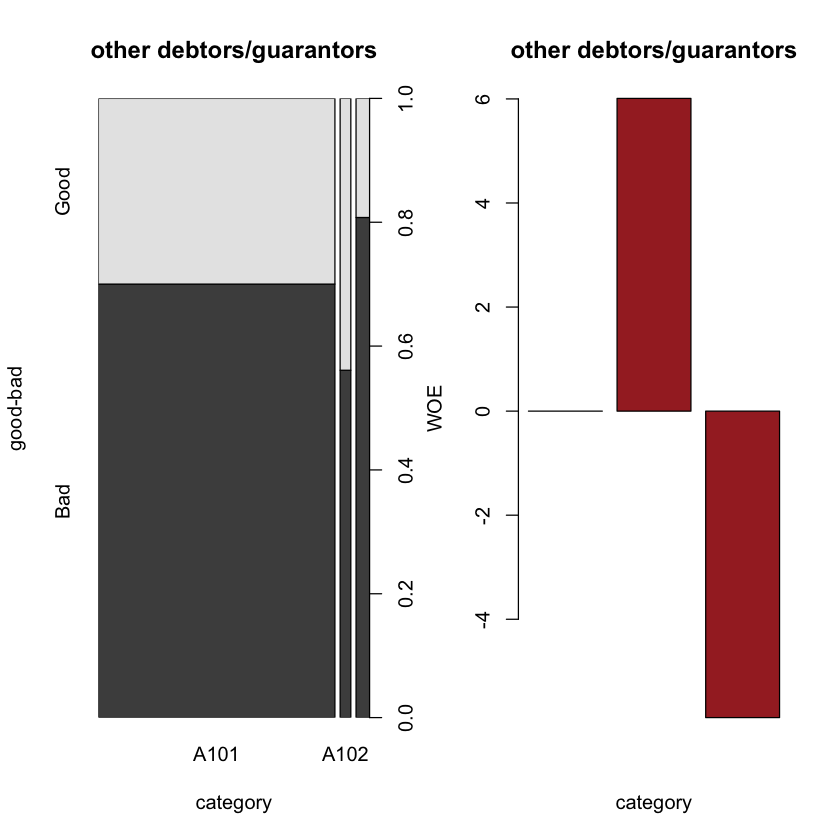

In [31]:
#other debtors/guarantors 

A10<-gbpct(cdata$other_debtors_or_grantors_10)
op10<-par(mfrow=c(1,2))
plot(cdata$other_debtors_or_grantors_10,cdata$good_bad_21,main="other debtors/guarantors",xlab="category",ylab="good-bad")
barplot(A10$WOE,col="brown",names.arg=c(A10$Levels),main="other debtors/guarantors",xlab="category",ylab="WOE")

In [32]:
kable(A10,caption="other debtors/guarantors~good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|A101  |  272| 635|    90.67|   90.71|   907|      90.7|    70.01|      5.00|  0.00| 0.00000|      0.020|
|A102  |   18|  23|     6.00|    3.29|    41|       4.1|    56.10|      6.46|  6.01| 1.62871|      1.355|
|A103  |   10|  42|     3.33|    6.00|    52|       5.2|    80.77|      3.57| -5.89| 1.57263|      1.335|

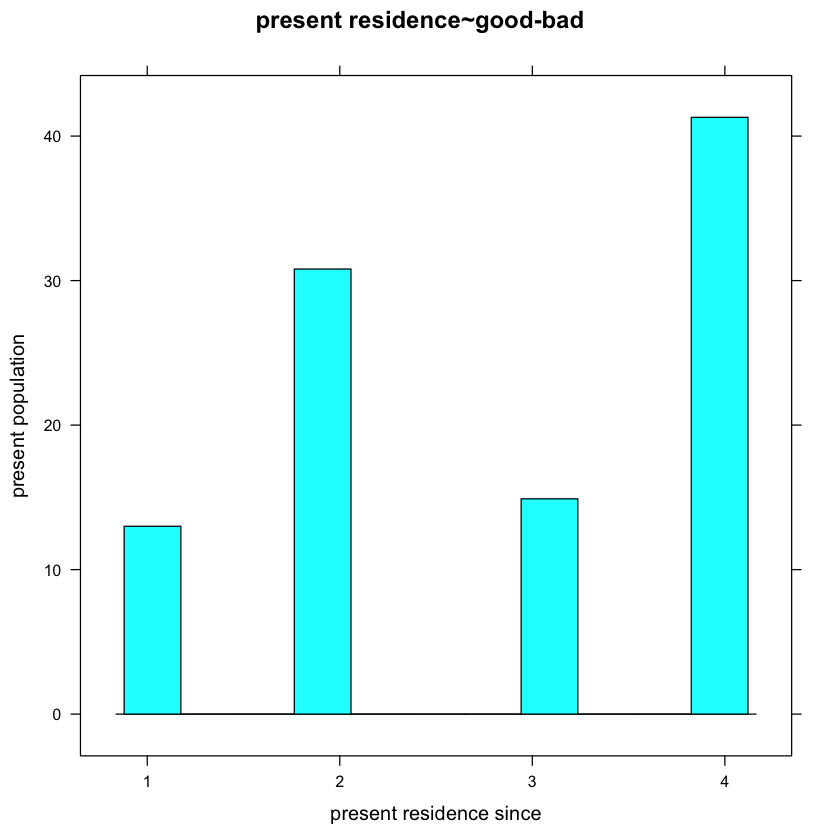

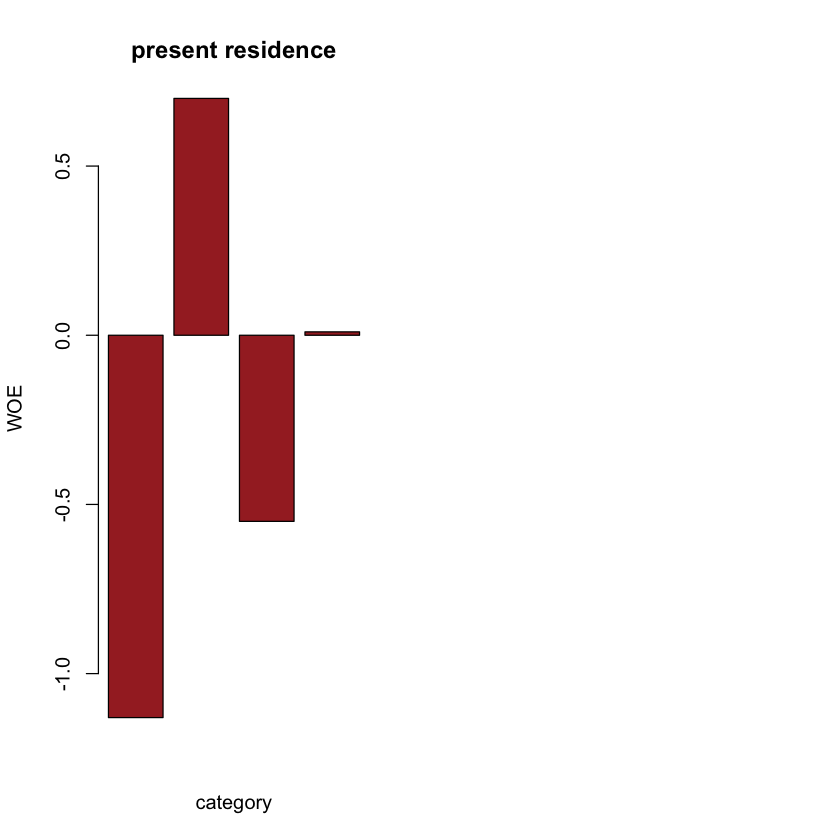

In [33]:
#present residence since 

A11<-gbpct(cdata$present_residence_since_11)
op11<-par(mfrow=c(1,2))
histogram(cdata$present_residence_since_11,main="present residence~good-bad",xlab="present residence since",ylab="present population")
barplot(A11$WOE,col="brown",names.arg=c(A11$Levels),main="present residence",xlab="category",ylab="WOE")

In [34]:
kable(A11,caption="present residence~good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|1     |   36|  94|    12.00|   13.43|   130|      13.0|    72.31|      4.72| -1.13| 0.16159|      0.715|
|2     |   97| 211|    32.33|   30.14|   308|      30.8|    68.51|      5.18|  0.70| 0.15330|      1.095|
|3     |   43| 106|    14.33|   15.14|   149|      14.9|    71.14|      4.86| -0.55| 0.04455|      0.405|
|4     |  124| 289|    41.33|   41.29|   413|      41.3|    69.98|      5.00|  0.01| 0.00004|      0.020|

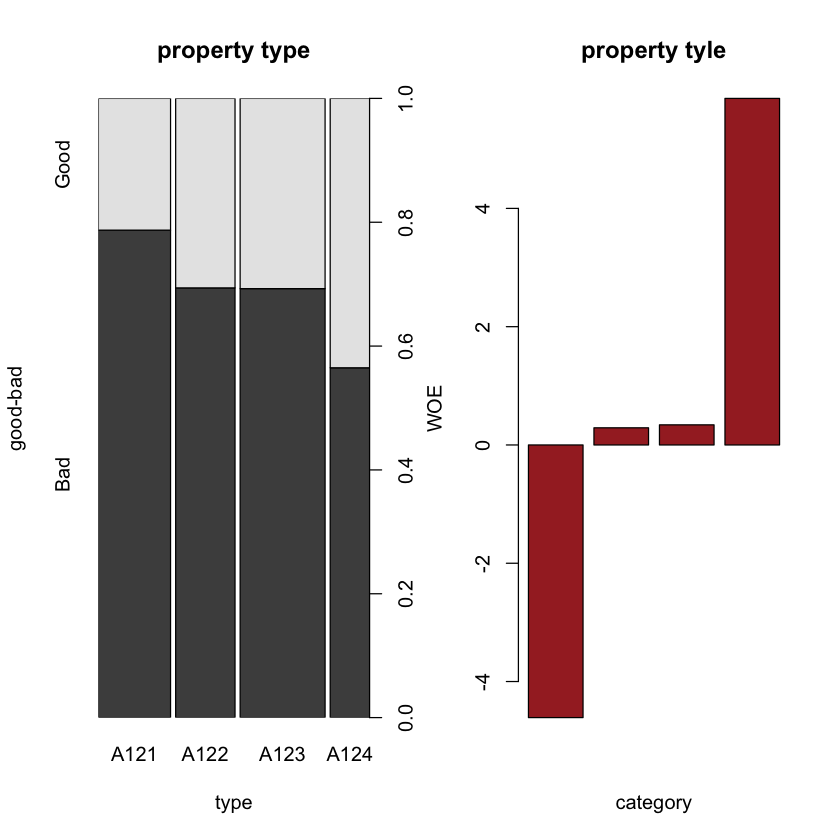

In [35]:
#property type 

A12<-gbpct(cdata$property_type_12)
op12<-par(mfrow=c(1,2))
plot(cdata$property_type_12,cdata$good_bad_21,main="property type",xlab="type",ylab="good-bad")
barplot(A12$WOE,col="brown",names.arg=c(A12$Levels),main="property tyle",xlab="category",ylab="WOE")

In [36]:
kable(A12,caption="property type")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|A121  |   60| 222|    20.00|   31.71|   282|      28.2|    78.72|      3.87| -4.61| 5.39831|      5.855|
|A122  |   71| 161|    23.67|   23.00|   232|      23.2|    69.40|      5.07|  0.29| 0.01943|      0.335|
|A123  |  102| 230|    34.00|   32.86|   332|      33.2|    69.28|      5.09|  0.34| 0.03876|      0.570|
|A124  |   67|  87|    22.33|   12.43|   154|      15.4|    56.49|      6.42|  5.86| 5.80140|      4.950|

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.00   27.00   33.00   35.55   42.00   75.00 

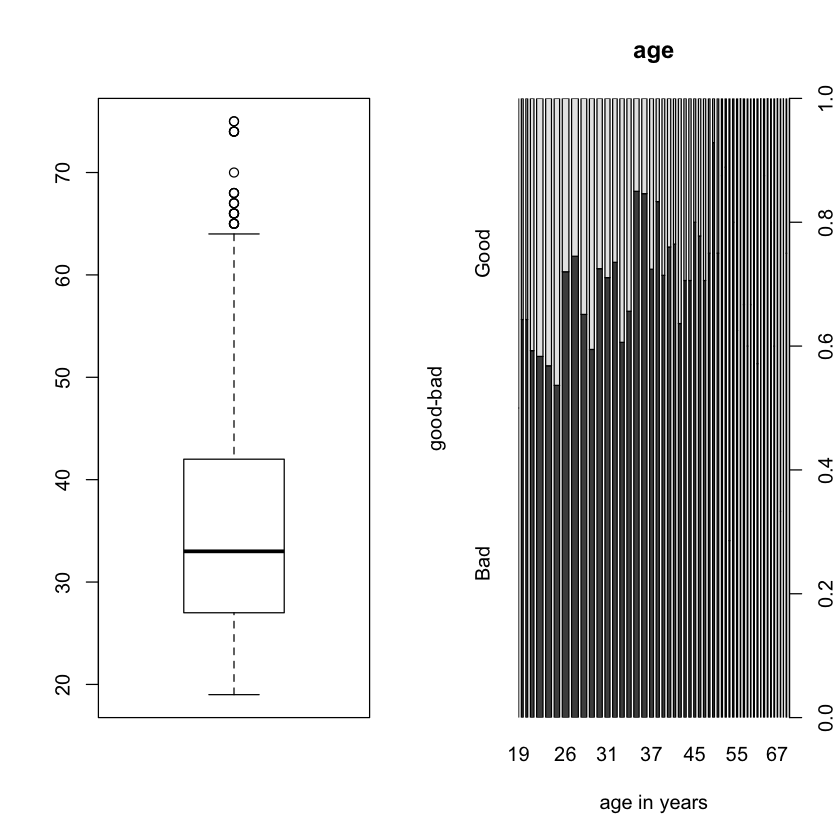

In [37]:
#Age in years

summary(cdata$age_in_yrs_13)
op13<-par(mfrow=c(1,2))
boxplot(cdata$age_in_yrs_13)
plot(as.factor(cdata$age_in_yrs_13),cdata$good_bad_21,main="age",xlab="age in years",ylab="good-bad")

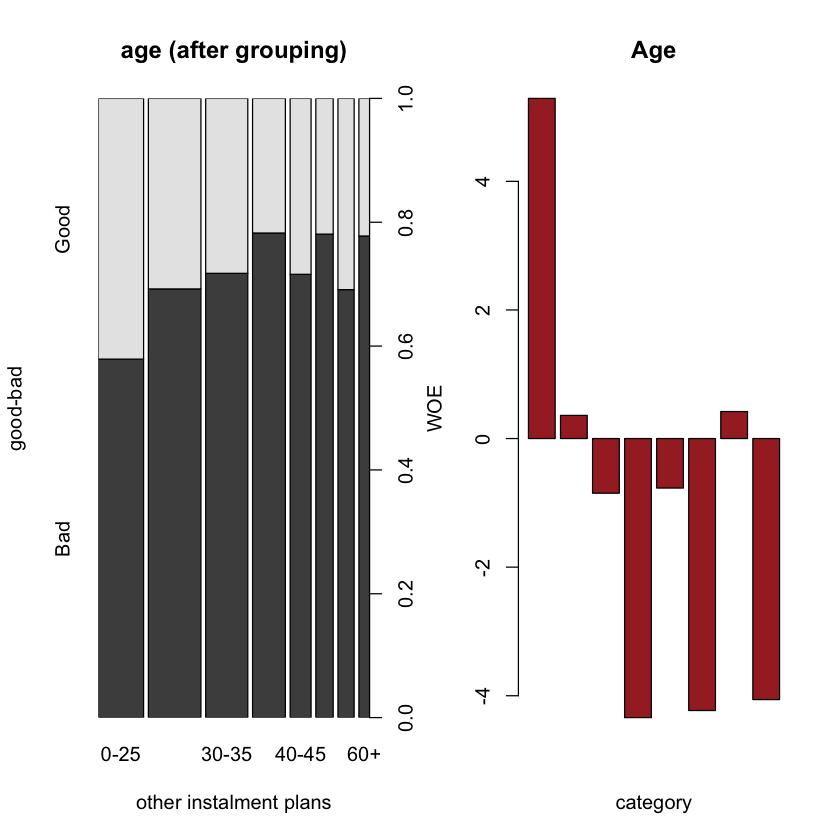

In [38]:
cdata$age_in_yrs_13<-as.factor(ifelse(cdata$age_in_yrs_13<=25,'0-25',ifelse(cdata$age_in_yrs_13<=30,'25-30',ifelse(cdata$age_in_yrs_13<=35,'30-35',ifelse(cdata$age_in_yrs_13<=40,'35-40',ifelse(cdata$age_in_yrs_13<=45,'40-45',ifelse(cdata$age_in_yrs_13<=50,'45-50',ifelse(cdata$age_in_yrs_13<=60,'50-60','60+'))))))))
A13<-gbpct(cdata$age_in_yrs_13)
op13_1<-par(mfrow=c(1,2))
plot(as.factor(cdata$age_in_yrs_13),cdata$good_bad_21,main="age (after grouping)",xlab="other instalment plans",ylab="good-bad")
barplot(A13$WOE,col="brown",names.arg=c(A13$Levels),main="Age",xlab="category",ylab="WOE")

In [39]:
kable(A13,caption="Age (After grouping)~good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|0-25  |   80| 110|    26.67|   15.71|   190|      19.0|    57.89|      6.29|  5.29| 5.79784|      5.480|
|25-30 |   68| 153|    22.67|   21.86|   221|      22.1|    69.23|      5.09|  0.36| 0.02916|      0.405|
|30-35 |   50| 127|    16.67|   18.14|   177|      17.7|    71.75|      4.79| -0.85| 0.12495|      0.735|
|35-40 |   30| 108|    10.00|   15.43|   138|      13.8|    78.26|      3.93| -4.34| 2.35662|      2.715|
|40-45 |   25|  63|     8.33|    9.00|    88|       8.8|    71.59|      4.81| -0.77| 0.05159|      0.335|
|45-50 |   16|  57|     5.33|    8.14|    73|       7.3|    78.08|      3.96| -4.23| 1.18863|      1.405|
|50-60 |   21|  47|     7.00|    6.71|    68|       6.8|    69.12|      5.11|  0.42| 0.01218|      0.145|
|60+   |   10|  35|     3.33|    5.00|    45

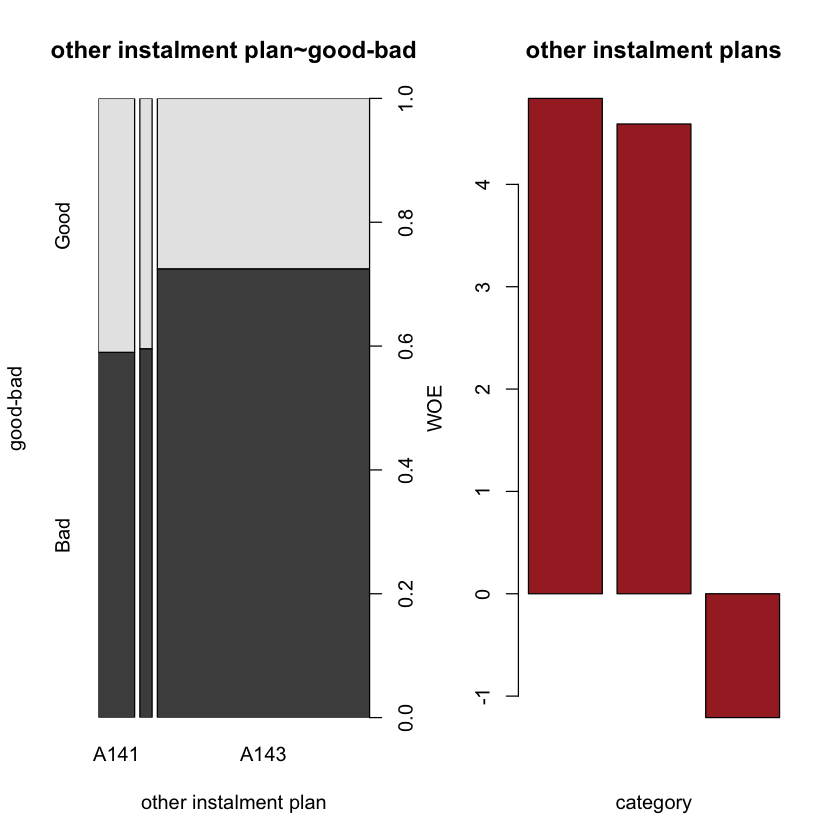

In [40]:
#other instalment plans 

A14<-gbpct(cdata$other_instalment_type_14)
op14<-par(mfrow=c(1,2))
plot(cdata$other_instalment_type_14,cdata$good_bad_21,main="other instalment plan~good-bad",xlab="other instalment plan",ylab="good-bad")
barplot(A14$WOE,col="brown",names.arg=c(A14$Levels),main="other instalment plans",xlab="category",ylab="WOE")

In [41]:
kable(A14,caption="other instalment plans~good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|A141  |   57|  82|    19.00|   11.71|   139|      13.9|    58.99|      6.19|  4.84| 3.52836|      3.645|
|A142  |   19|  28|     6.33|    4.00|    47|       4.7|    59.57|      6.13|  4.59| 1.06947|      1.165|
|A143  |  224| 590|    74.67|   84.29|   814|      81.4|    72.48|      4.70| -1.21| 1.16402|      4.810|

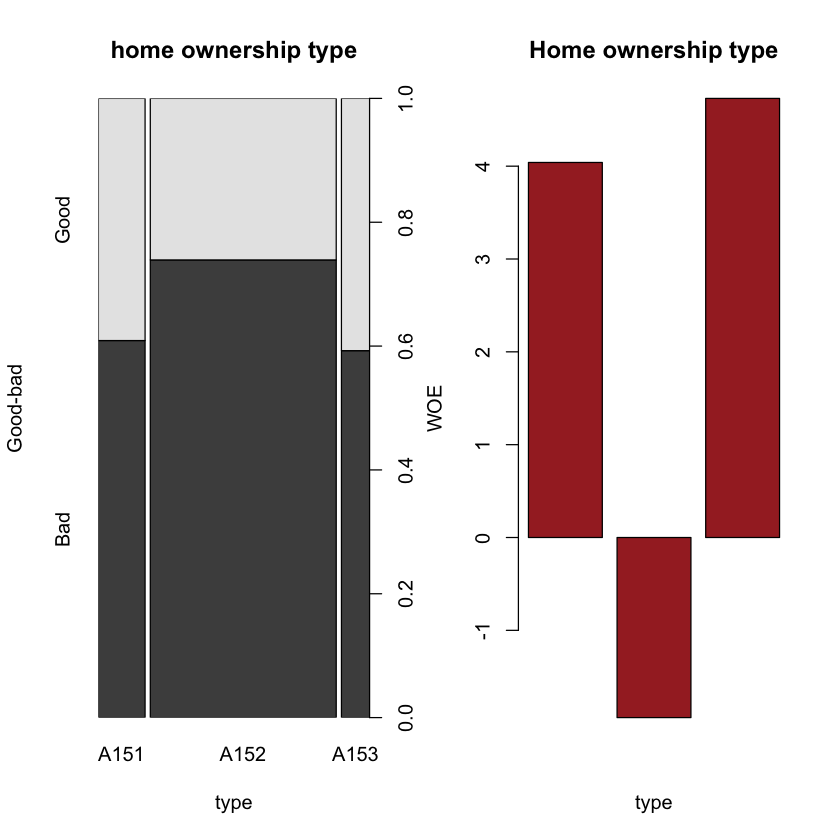

In [42]:
#Housing Type 

A15<-gbpct(cdata$housing_type_15)
op15<-par(mfrow=c(1,2))
plot(cdata$housing_type_15,cdata$good_bad_21,main="home ownership type",xlab="type",ylab="Good-bad")
barplot(A15$WOE,col="brown",names.arg=c(A15$Levels),main="Home ownership type",xlab="type",ylab="WOE")

In [43]:
kable(A15,caption="Home ownership type~good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|A151  |   70| 109|    23.33|   15.57|   179|      17.9|    60.89|      6.00|  4.04| 3.13504|      3.880|
|A152  |  186| 527|    62.00|   75.29|   713|      71.3|    73.91|      4.52| -1.94| 2.57826|      6.645|
|A153  |   44|  64|    14.67|    9.14|   108|      10.8|    59.26|      6.16|  4.73| 2.61569|      2.765|

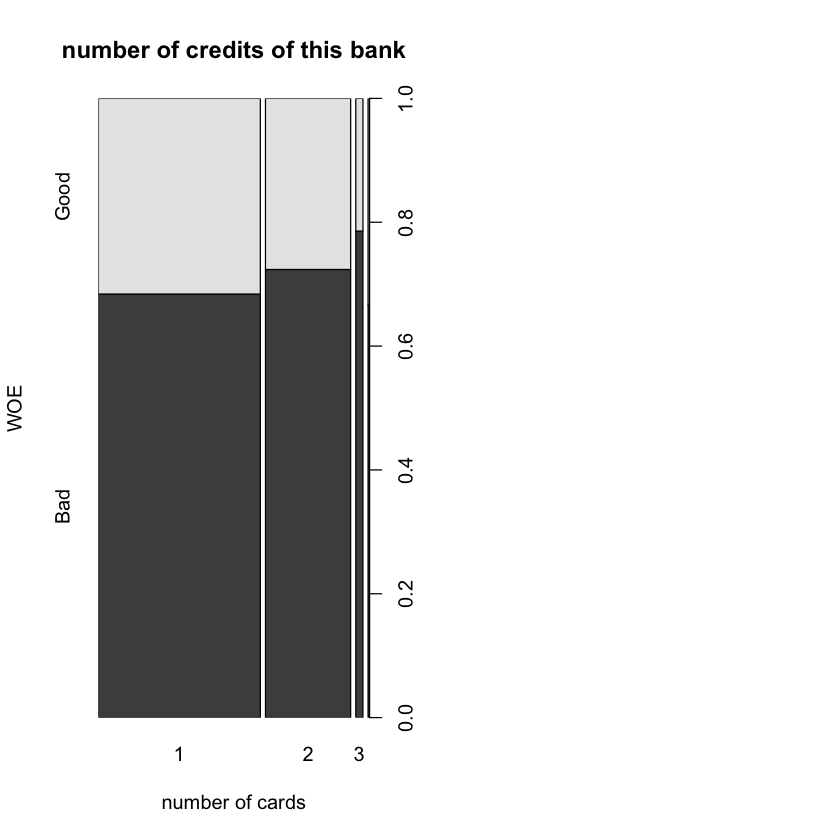

In [44]:
#number of existing credits at this bank 

A16<-gbpct(cdata$number_cards_this_bank_16)
op16<-par(mfrow=c(1,2))
plot(as.factor(cdata$number_cards_this_bank_16),cdata$good_bad_21,main="number of credits of this bank",xlab="number of cards",ylab="WOE")

In [45]:
kable(A16,caption="number of credits at this bank ~good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|1     |  200| 433|    66.67|   61.86|   633|      63.3|    68.40|      5.19|  0.75| 0.36075|      2.405|
|2     |   92| 241|    30.67|   34.43|   333|      33.3|    72.37|      4.71| -1.16| 0.43616|      1.880|
|3     |    6|  22|     2.00|    3.14|    28|       2.8|    78.57|      3.89| -4.51| 0.51414|      0.570|
|4     |    2|   4|     0.67|    0.57|     6|       0.6|    66.67|      5.40|  1.62| 0.01620|      0.050|

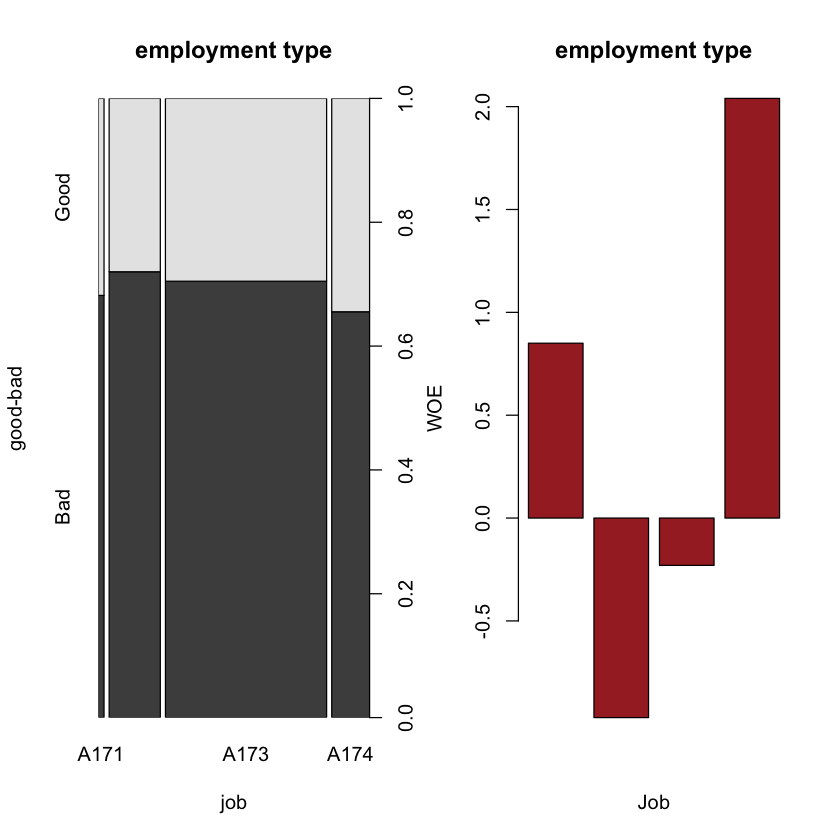

In [46]:
#job status 

A17<-gbpct(cdata$job_17)
op17<-par(mfrow=c(1,2))
plot(cdata$job_17,cdata$good_bad_21,main="employment type",xlab="job",ylab="good-bad")
barplot(A17$WOE,col="brown",names.arg=c(A17$Levels),main="employment type",xlab="Job",ylab="WOE")

In [47]:
kable(A17,caption="employment type~good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|A171  |    7|  15|     2.33|    2.14|    22|       2.2|    68.18|      5.21|  0.85| 0.01615|      0.095|
|A172  |   56| 144|    18.67|   20.57|   200|      20.0|    72.00|      4.76| -0.97| 0.18430|      0.950|
|A173  |  186| 444|    62.00|   63.43|   630|      63.0|    70.48|      4.94| -0.23| 0.03289|      0.715|
|A174  |   51|  97|    17.00|   13.86|   148|      14.8|    65.54|      5.51|  2.04| 0.64056|      1.570|

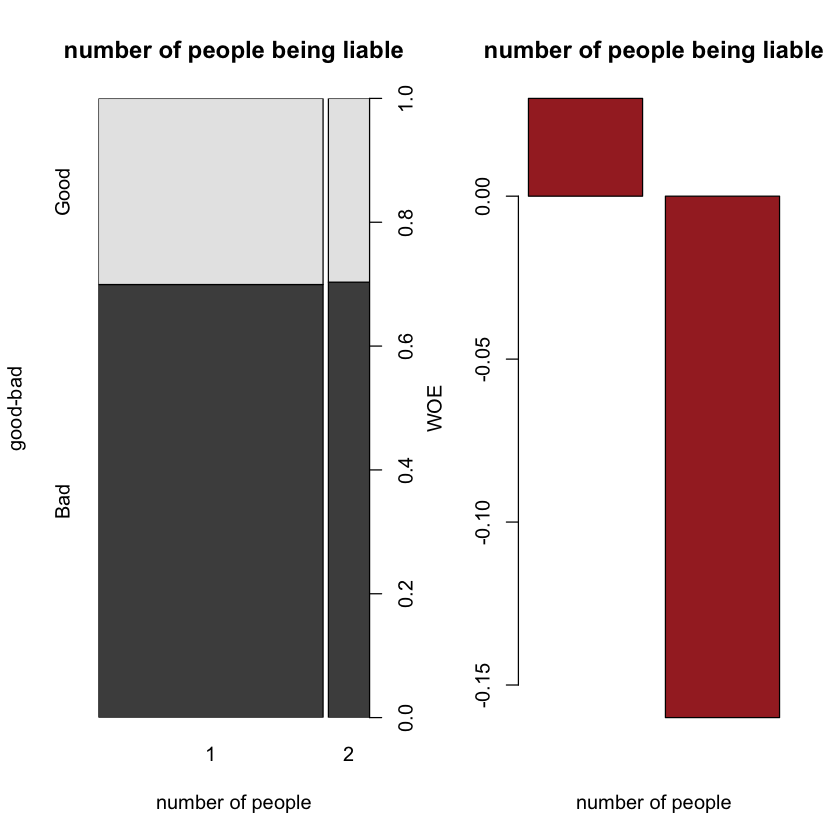

In [48]:
#number of people being liable to provide maintenance for 

A18<-gbpct(cdata$no_people_liable_for_mntnance_18)
op18<-par(mfrow=c(1,2))
plot(as.factor(cdata$no_people_liable_for_mntnance_18),cdata$good_bad_21,main="number of people being liable",xlab="number of people",ylab="good-bad")
barplot(A18$WOE,col="brown",names.arg=c(A18$Levels),main="number of people being liable",xlab="number of people",ylab="WOE")

In [49]:
kable(A18,caption="number of people being liable -good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|      IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|-------:|----------:|
|1     |  254| 591|    84.67|   84.43|   845|      84.5|    69.94|      5.01|  0.03| 0.00072|       0.12|
|2     |   46| 109|    15.33|   15.57|   155|      15.5|    70.32|      4.96| -0.16| 0.00384|       0.12|

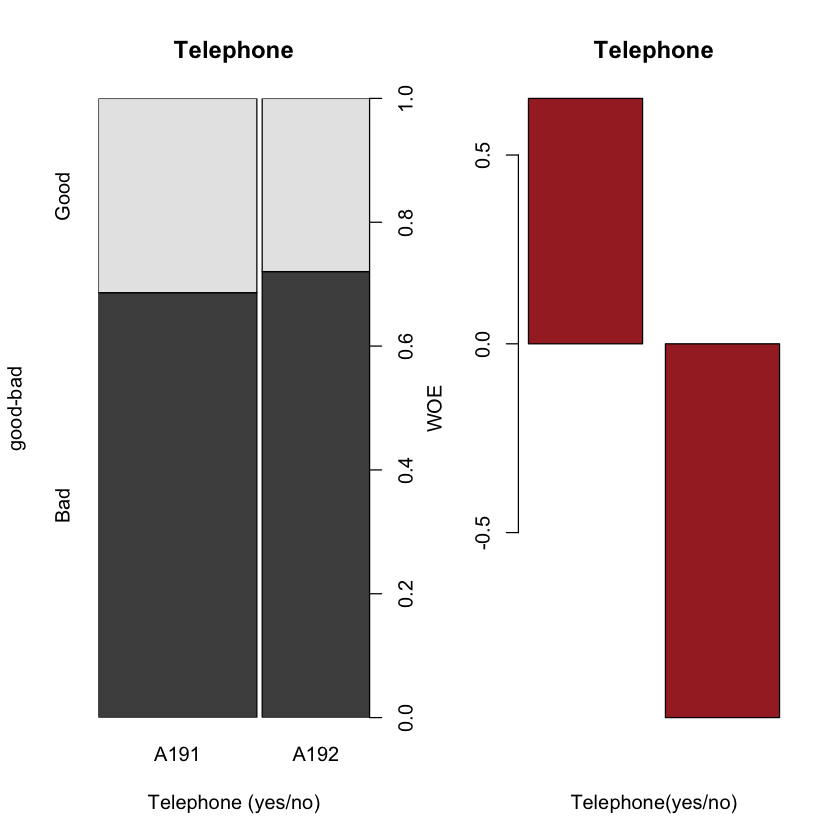

In [50]:
#Telephone number (Yes/No)
A19<-gbpct(cdata$telephone_19)
op19<-par(mfrow=c(1,2))
plot(cdata$telephone_19,cdata$good_bad_21,main="Telephone",xlab="Telephone (yes/no)",ylab="good-bad")
barplot(A19$WOE,col="brown",names.arg=c(A19$Levels),main="Telephone",xlab="Telephone(yes/no)",ylab="WOE")

In [51]:
kable(A19,caption="Telephone~Good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|   WOE|     IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|-----:|------:|----------:|
|A191  |  187| 409|    62.33|   58.43|   596|      59.6|    68.62|      5.16|  0.65| 0.2535|       1.95|
|A192  |  113| 291|    37.67|   41.57|   404|      40.4|    72.03|      4.75| -0.99| 0.3861|       1.95|

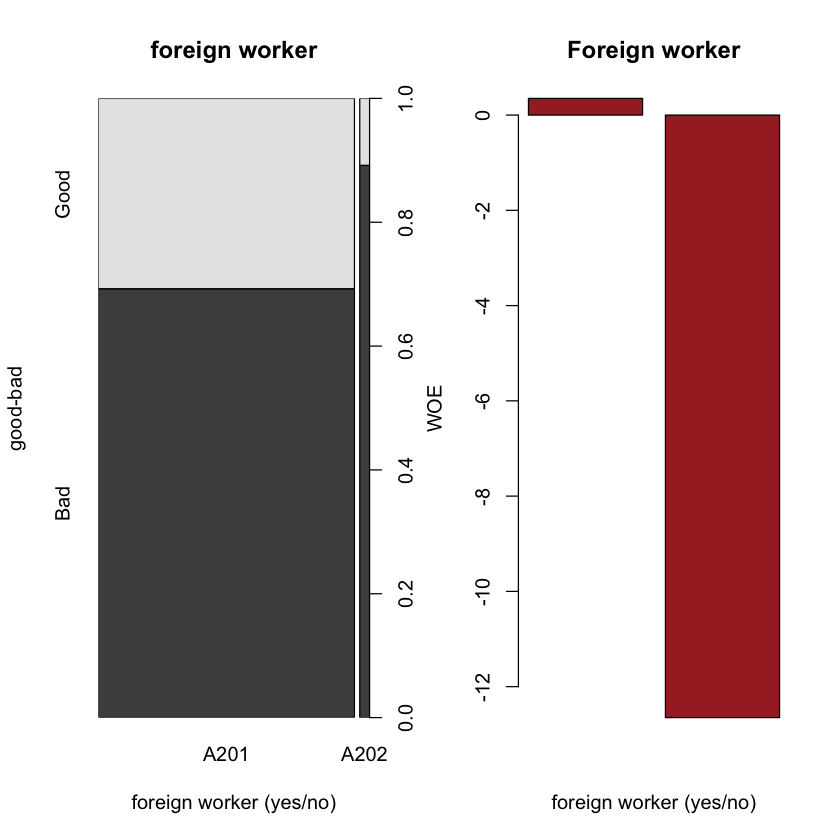

In [52]:
# Foreign workers (Yes/No)

A20<-gbpct(cdata$foreign_worker_20)
op20<-par(mfrow=c(1,2))
plot(cdata$foreign_worker_20,cdata$good_bad_21,main="foreign worker",xlab="foreign worker (yes/no)",ylab="good-bad")
barplot(A20$WOE,col="brown",names.arg=c(A20$Levels),main="Foreign worker",xlab="foreign worker (yes/no)",ylab="WOE")

In [53]:
kable(A20,caption="foreign worker~good-bad")



|Names | Good| Bad| Good_pct| Bad_pct| Total| Total_Pct| Bad_Rate| grp_score|    WOE|     IV| Efficiency|
|:-----|----:|---:|--------:|-------:|-----:|---------:|--------:|---------:|------:|------:|----------:|
|A201  |  296| 667|    98.67|   95.29|   963|      96.3|    69.26|      5.09|   0.35| 0.1183|       1.69|
|A202  |    4|  33|     1.33|    4.71|    37|       3.7|    89.19|      2.20| -12.65| 4.2757|       1.69|

In [54]:
#Information value (IV) and Weight of Evidence (WOE)

cdata$good_bad_21<-as.numeric(ifelse(cdata$good_bad_21=="Good",0,1))

IV<-Information:: create_infotables(data=cdata,NULL,y="good_bad_21",10)
IV$Summary$IV<-round(IV$Summary$IV*100,2)
kable(IV$Summary)



|   |Variable                         |    IV|
|:--|:--------------------------------|-----:|
|1  |chk_ac_status_1                  | 66.60|
|3  |credit_history_3                 | 29.32|
|2  |duration_month_2                 | 25.50|
|6  |savings_ac_bond_6                | 19.60|
|4  |purpose_4                        | 16.92|
|12 |property_type_12                 | 11.26|
|13 |age_in_yrs_13                    | 10.23|
|5  |credit_amount_5                  |  9.38|
|7  |p_employment_since_7             |  8.64|
|15 |housing_type_15                  |  8.33|
|14 |other_instalment_type_14         |  5.76|
|9  |personal_status_9                |  4.47|
|20 |foreign_worker_20                |  4.39|
|10 |other_debtors_or_grantors_10     |  3.20|
|8  |instalment_pct_8                 |  2.63|
|16 |number_cards_this_bank_16        |  1.01|
|17 |job_17                           |  0.88|
|19 |telephone_19                     |  0.64|
|11 |present_residence_since_11       |  0.36|
|18 |no_peo

In [55]:
cdata$good_bad_21<-as.factor(ifelse(cdata$good_bad_21 == 0, "Good", "Bad"))

In [56]:
#Subset Data 1- Based on Univariate and Bivariate Analysis

var_list_1 <- IV$Summary[IV$Summary$IV > 2,] # 15 variables

cdata_reduced_1 <- cdata[, c(var_list_1$Variable,"good_bad_21")] #16 variables

In [57]:
# Multivariate - dimention reduction using variable clustering approach 

# Step 1: Subset quantitative and qualitative variables X.quanti and X.quali

factors <- sapply(cdata_reduced_1, is.factor)

#subset Qualitative variables

vars_quali <- cdata_reduced_1[,factors]

str(vars_quali)

'data.frame':	1000 obs. of  15 variables:
 $ chk_ac_status_1             : Factor w/ 4 levels "A11","A12","A13",..: 1 2 4 1 1 4 4 2 4 2 ...
 $ credit_history_3            : Factor w/ 4 levels "01.A3O","02.A31",..: 4 3 4 3 3 3 3 3 3 4 ...
 $ duration_month_2            : Factor w/ 7 levels "00-06","06-12",..: 1 7 2 6 3 5 3 5 2 4 ...
 $ savings_ac_bond_6           : Factor w/ 5 levels "A61","A62","A63",..: 5 1 1 1 1 5 3 1 4 1 ...
 $ purpose_4                   : Factor w/ 10 levels "A40","A41","A410",..: 5 5 8 4 1 8 4 2 5 1 ...
 $ property_type_12            : Factor w/ 4 levels "A121","A122",..: 1 1 1 2 4 4 2 3 1 3 ...
 $ age_in_yrs_13               : Factor w/ 8 levels "0-25","25-30",..: 8 1 6 5 7 3 7 3 8 2 ...
 $ credit_amount_5             : Factor w/ 6 levels "0-1400","1400-2500",..: 1 6 2 6 5 6 3 6 3 5 ...
 $ p_employment_since_7        : Factor w/ 5 levels "A71","A72","A73",..: 5 3 4 4 3 3 5 3 4 1 ...
 $ housing_type_15             : Factor w/ 3 levels "A151","A152",..: 2 2 2 3 3 

In [58]:
#subset Quantitative variables

vars_quanti <- cdata_reduced_1[,!factors]
vars_quanti<-data.frame(vars_quanti)
str(vars_quanti)

'data.frame':	1000 obs. of  1 variable:
 $ vars_quanti: num  4 2 2 2 3 2 3 2 2 4 ...


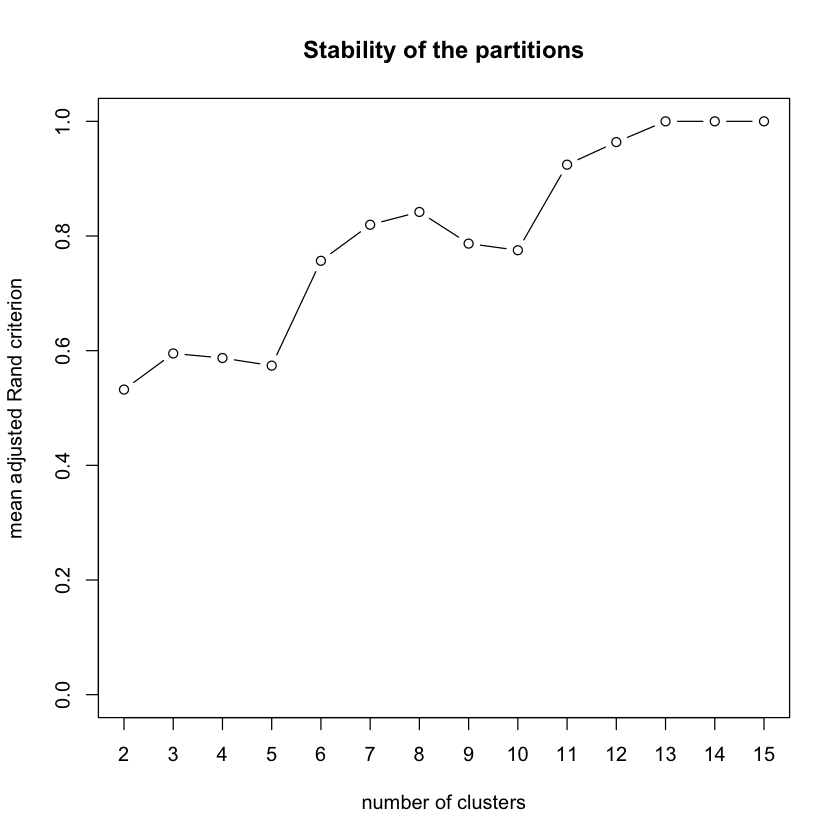

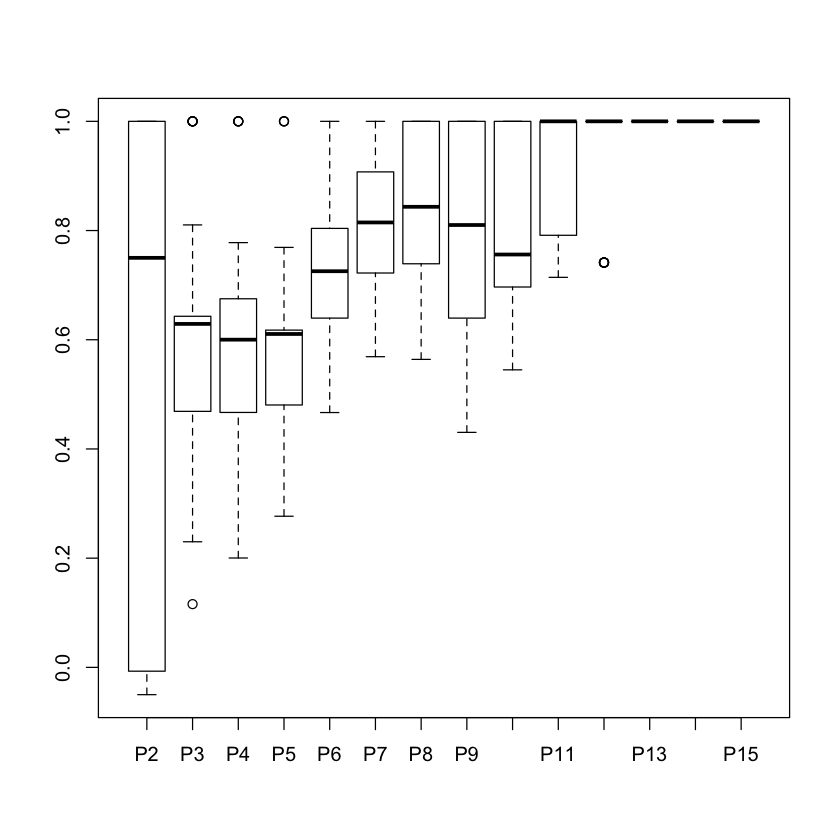

In [59]:
#Step 2: Hierarchical Clustering of Variables
# requires library(ClustOfVar)

#Bootstrap 50 times 
tree <- hclustvar(X.quanti=vars_quanti,X.quali=vars_quali)
stab<-stability(tree,B=50)

boxplot(stab$matCR)

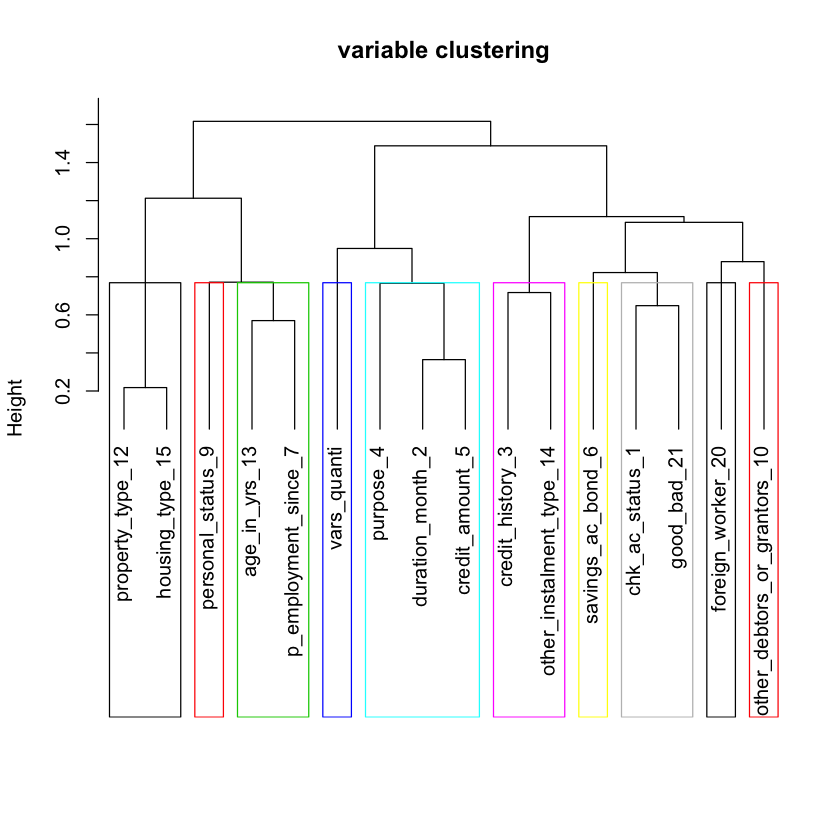

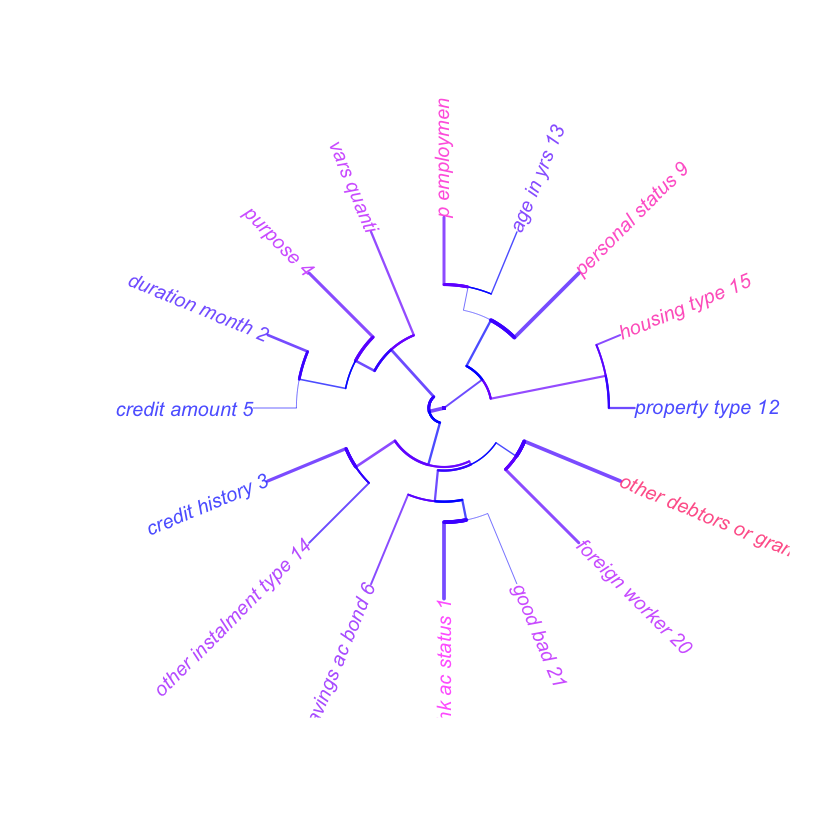

In [60]:
plot(tree, main="variable clustering")
rect.hclust(tree, k=10, border = 1:10)


# Phylogenetic trees
# require library("ape")

plot(as.phylo(tree), type = "fan",
     tip.color = hsv(runif(15, 0.65, 0.95), 1, 1, 0.7),
     edge.color = hsv(runif(10, 0.65, 0.75), 1, 1, 0.7),
     edge.width = runif(20, 0.5, 3), use.edge.length = TRUE, col = "gray80")

In [61]:
summary.phylo(as.phylo(tree))


Phylogenetic tree: as.phylo(tree) 

  Number of tips: 16 
  Number of nodes: 15 
  Branch lengths:
    mean: 0.2473574 
    variance: 0.0187277 
    distribution summary:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
0.01508197 0.11469556 0.21124309 0.35857831 0.49734608 
  No root edge.
  First ten tip labels: vars_quanti 
                        chk_ac_status_1
                        credit_history_3
                        duration_month_2
                        savings_ac_bond_6
                        purpose_4
                        property_type_12
                        age_in_yrs_13
                        credit_amount_5
                        p_employment_since_7
  No node labels.


In [62]:
#Subset data-2: based on variable clustering 

keep<- c(1:8,12,13,21)

cdata_reduced_2 <- cdata[,keep]

str(cdata_reduced_2)

'data.frame':	1000 obs. of  11 variables:
 $ chk_ac_status_1     : Factor w/ 4 levels "A11","A12","A13",..: 1 2 4 1 1 4 4 2 4 2 ...
 $ duration_month_2    : Factor w/ 7 levels "00-06","06-12",..: 1 7 2 6 3 5 3 5 2 4 ...
 $ credit_history_3    : Factor w/ 4 levels "01.A3O","02.A31",..: 4 3 4 3 3 3 3 3 3 4 ...
 $ purpose_4           : Factor w/ 10 levels "A40","A41","A410",..: 5 5 8 4 1 8 4 2 5 1 ...
 $ credit_amount_5     : Factor w/ 6 levels "0-1400","1400-2500",..: 1 6 2 6 5 6 3 6 3 5 ...
 $ savings_ac_bond_6   : Factor w/ 5 levels "A61","A62","A63",..: 5 1 1 1 1 5 3 1 4 1 ...
 $ p_employment_since_7: Factor w/ 5 levels "A71","A72","A73",..: 5 3 4 4 3 3 5 3 4 1 ...
 $ instalment_pct_8    : num  4 2 2 2 3 2 3 2 2 4 ...
 $ property_type_12    : Factor w/ 4 levels "A121","A122",..: 1 1 1 2 4 4 2 3 1 3 ...
 $ age_in_yrs_13       : Factor w/ 8 levels "0-25","25-30",..: 8 1 6 5 7 3 7 3 8 2 ...
 $ good_bad_21         : Factor w/ 2 levels "Bad","Good": 1 2 1 1 2 1 1 1 1 2 ...


In [63]:
# Random sampling (Train and Test)

#We may split the data (given population) into random samples with 50-50, 60-40 or 70-30 ratios for Training (Development Sample on which model will be developed or trained) and Test (validation/holdout sample on which model will be tested) based on population size. In this exercise we will split the sample into 70-30. You may perform this step even before Univariate analysis.

# Simple Random sampling 

#Simple random sampling is the most basic sampling technique where we select a group of subjects (a sample) for study from a larger group (a population). Each individual is chosen entirely by chance and each member of the population has an equal chance of being included in the sample

div_part <- sort(sample(nrow(cdata_reduced_2), nrow(cdata_reduced_2)*.6))

#select training sample 

train<-cdata_reduced_2[div_part,] # 60% here
pct(train$good_bad_21)

# put remaining into test sample
test<-cdata_reduced_2[-div_part,] # rest of the 40% data goes here
pct(test$good_bad_21)



|     | Count| Percentage|
|:----|-----:|----------:|
|Bad  |   432|         72|
|Good |   168|         28|



|     | Count| Percentage|
|:----|-----:|----------:|
|Bad  |   268|         67|
|Good |   132|         33|

In [64]:
#Logistic Regression 
m1 <- glm(good_bad_21~.,data=train,family=binomial())
m1 <- step(m1)
summary(m1)

Start:  AIC=594.55
good_bad_21 ~ chk_ac_status_1 + duration_month_2 + credit_history_3 + 
    purpose_4 + credit_amount_5 + savings_ac_bond_6 + p_employment_since_7 + 
    instalment_pct_8 + property_type_12 + age_in_yrs_13

                       Df Deviance    AIC
- credit_amount_5       5   509.07 591.07
- property_type_12      3   507.19 593.19
- age_in_yrs_13         7   515.46 593.46
- p_employment_since_7  4   510.20 594.20
<none>                      502.55 594.55
- purpose_4             9   521.50 595.50
- instalment_pct_8      1   508.34 598.34
- duration_month_2      6   522.16 602.16
- chk_ac_status_1       3   524.48 610.48
- savings_ac_bond_6     4   527.26 611.26
- credit_history_3      3   531.01 617.01

Step:  AIC=591.07
good_bad_21 ~ chk_ac_status_1 + duration_month_2 + credit_history_3 + 
    purpose_4 + savings_ac_bond_6 + p_employment_since_7 + instalment_pct_8 + 
    property_type_12 + age_in_yrs_13

                       Df Deviance    AIC
- property_type_12    


Call:
glm(formula = good_bad_21 ~ chk_ac_status_1 + duration_month_2 + 
    credit_history_3 + purpose_4 + savings_ac_bond_6 + p_employment_since_7 + 
    instalment_pct_8 + age_in_yrs_13, family = binomial(), data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9771  -0.6754  -0.3583   0.5939   2.6988  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  0.7421     0.9526   0.779 0.435928    
chk_ac_status_1A12          -0.4623     0.2830  -1.634 0.102274    
chk_ac_status_1A13          -1.3036     0.5289  -2.465 0.013710 *  
chk_ac_status_1A14          -1.2762     0.2974  -4.291 1.78e-05 ***
duration_month_206-12        0.9541     0.6327   1.508 0.131574    
duration_month_212-24        1.4829     0.6178   2.400 0.016389 *  
duration_month_224-30        1.4243     0.7666   1.858 0.063181 .  
duration_month_230-36        2.5627     0.6832   3.751 0.000176 ***
duration_month_236-42        1.895

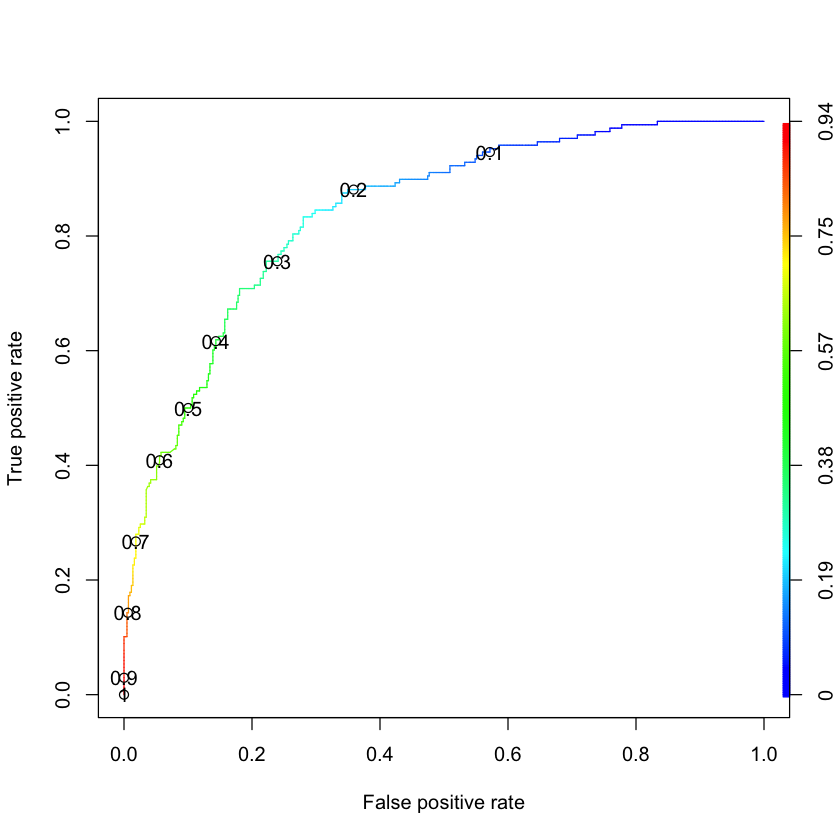

In [65]:
#ROC (Receiver Operating Characteristic) curve 

pred1<-predict(m1,train,type="response")

ROCRPred<-prediction(pred1,train$good_bad_21)

ROCRPref<-performance(ROCRPred,"tpr","fpr")

plot(ROCRPref,colorize=TRUE,print.cutoffs.at=seq(0.1,by=0.1))

In [67]:
#confusion matrix
pred<-predict(m1,test,type="response")

table(ActualValue=test$good_bad_21,PredictedValue=pred>0.2)

           PredictedValue
ActualValue FALSE TRUE
       Bad    168  100
       Good    35   97

In [68]:
#predictability
(168+97)/(168+100+35+97)

[1] 0.6625